In [100]:
%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import metrics

#%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
#plt.rcParams['figure.figsize'] = (16, 9)
#plt.style.use('ggplot')


from itertools import cycle
import networkx as nx



from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC

from matplotlib_venn import venn2
from matplotlib_venn import venn3
from lineage import get_lineage_coll, get_lineage_snp
from resistance import get_resistance_snp
from coinfection_functions import import_VCF42_to_pandas, filter_repeats, add_snp_distance, \
                            scatter_vcf_pos, distplot_sns, add_window_distance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
pd.set_option('display.max_columns', None)

In [45]:
sample_list = []
vcf_files = []
directory = "coinf_it"

for file in os.listdir(directory):
    if file.endswith(".vcf"):
        name = file.split(".")[0]
        sample_list.append(name)
        file_path = os.path.join(directory, file)
        vcf_files.append(file_path)
        
sample_list.sort()
vcf_files.sort()

print(sample_list)
print(vcf_files)

['1mixed', '2mixed', '3mixed', '4mixed', '5mixed', '6mixed', '7mixed']
['coinf_it/1mixed.snp.hf.pass.vcf', 'coinf_it/2mixed.snp.hf.pass.vcf', 'coinf_it/3mixed.snp.hf.pass.vcf', 'coinf_it/4mixed.snp.hf.pass.vcf', 'coinf_it/5mixed.snp.hf.pass.vcf', 'coinf_it/6mixed.snp.hf.pass.vcf', 'coinf_it/7mixed.snp.hf.pass.vcf']


# Import vcf as dataframe

In [46]:
x = datetime.datetime.now()
print(x)
dict_vcf = {}
for vcf, df_name in zip(vcf_files, sample_list):
    dict_vcf[df_name] = import_VCF42_to_pandas(vcf)
y = datetime.datetime.now()
print(y)
print("Done with import in: %s" % (y - x))

2019-06-04 16:53:35.497122
2019-06-04 16:55:09.782819
Done with import in: 0:01:34.285697


In [47]:
dict_vcf[sample_list[2]].head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample,AC,af,AN,BaseQRankSum,DP,ExcessHet,FS,MQ,MQRankSum,QD,ReadPosRankSum,SOR,GT,AD,GQ,PL,PGT,PID,PS,len_AD,REF_AD,ALT_AD,gt0,gt1,dp,aF,AF
0,MTB_anc,237,.,G,A,2955.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-4.350e+00;DP=...,GT:AD:DP:GQ:PL,"0/1:22,111:133:99:2966,0,405",1.0,0.5,2.0,-4.350,133.0,3.0103,4.440,60.0,0.0,22.22,0.264,0.533,0/1,"22,111",99.0,"2966,0,405",NaN,NaN,NaN,2,22.0,111.0,0,1,133.0,0.165414,0.834586
1,MTB_anc,4191,.,A,G,2466.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=2.15;DP=106;Ex...,GT:AD:DP:GQ:PL,"0/1:21,85:106:99:2477,0,294",1.0,0.5,2.0,2.150,106.0,3.0103,3.280,60.0,0.0,23.27,-0.389,0.615,0/1,"21,85",99.0,"2477,0,294",NaN,NaN,NaN,2,21.0,85.0,0,1,106.0,0.198113,0.801887
2,MTB_anc,5075,.,C,T,3452.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-3.797e+00;DP=...,GT:AD:DP:GQ:PL,"0/1:32,128:160:99:3463,0,649",1.0,0.5,2.0,-3.797,160.0,3.0103,0.000,60.0,0.0,21.58,-1.129,0.724,0/1,"32,128",99.0,"3463,0,649",NaN,NaN,NaN,2,32.0,128.0,0,1,160.0,0.200000,0.800000
3,MTB_anc,6112,.,G,C,2710.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-1.172e+00;DP=...,GT:AD:DP:GQ:PL,"0/1:13,103:116:65:2721,0,65",1.0,0.5,2.0,-1.172,116.0,3.0103,1.140,60.0,0.0,23.37,1.910,0.458,0/1,"13,103",65.0,"2721,0,65",NaN,NaN,NaN,2,13.0,103.0,0,1,116.0,0.112069,0.887931
4,MTB_anc,8452,.,C,T,2916.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-3.101e+00;DP=...,GT:AD:DP:GQ:PL,"0/1:32,114:146:99:2927,0,678",1.0,0.5,2.0,-3.101,146.0,3.0103,0.745,60.0,0.0,19.98,-1.051,0.582,0/1,"32,114",99.0,"2927,0,678",NaN,NaN,NaN,2,32.0,114.0,0,1,146.0,0.219178,0.780822


In [48]:
dict_vcf[sample_list[2]].columns

Index(['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'sample', 'AC', 'af', 'AN', 'BaseQRankSum', 'DP', 'ExcessHet', 'FS',
       'MQ', 'MQRankSum', 'QD', 'ReadPosRankSum', 'SOR', 'GT', 'AD', 'GQ',
       'PL', 'PGT', 'PID', 'PS', 'len_AD', 'REF_AD', 'ALT_AD', 'gt0', 'gt1',
       'dp', 'aF', 'AF'],
      dtype='object')

# Add repeat and snp distance info

In [49]:
#dict_vcf = {}

for name, vcf_df in dict_vcf.items():
    #Add repeat info (Phage, Transposon or PE/PPE regions)
    vcf_df['Is_repeat'] = vcf_df.apply(filter_repeats, axis=1)

    #Add info of nearby positions
    add_snp_distance(vcf_df)
    
    #Add info of clustered positions in sliding window
    add_window_distance(vcf_df, window_size=10)

In [50]:
dict_vcf[sample_list[2]].columns

Index(['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'sample', 'AC', 'af', 'AN', 'BaseQRankSum', 'DP', 'ExcessHet', 'FS',
       'MQ', 'MQRankSum', 'QD', 'ReadPosRankSum', 'SOR', 'GT', 'AD', 'GQ',
       'PL', 'PGT', 'PID', 'PS', 'len_AD', 'REF_AD', 'ALT_AD', 'gt0', 'gt1',
       'dp', 'aF', 'AF', 'Is_repeat', 'snp_left_distance',
       'snp_right_distance', 'Window_10'],
      dtype='object')

# Create a set of filtered df in different dictionary

In [51]:
dict_dff = {}
distance = 20
QD = 2
for name, df_vcf in dict_vcf.items():
    list_positions_to_filter = df_vcf['POS'][(
                                (df_vcf.snp_left_distance <= distance)|
                                (df_vcf.snp_right_distance <= distance)|
                                (df_vcf.Window_10 >= 3)|
                                (df_vcf.Is_repeat == True) |
                                (df_vcf.AF <= 0.0) |
                                (df_vcf.len_AD > 2) |
                                (df_vcf.QD <= QD))].tolist()
    dict_dff[name] = df_vcf[~df_vcf.POS.isin(list_positions_to_filter)]

In [52]:
dict_vcf[sample_list[2]][dict_vcf[sample_list[2]].AF < 0.5].QD.describe()

count    1052.000000
mean       15.538232
std        10.111281
min         2.000000
25%         4.427500
50%        16.645000
75%        24.682500
max        60.000000
Name: QD, dtype: float64

In [53]:
dict_vcf[sample_list[2]][dict_vcf[sample_list[2]].snp_left_distance <= 30].head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample,AC,af,AN,BaseQRankSum,DP,ExcessHet,FS,MQ,MQRankSum,QD,ReadPosRankSum,SOR,GT,AD,GQ,PL,PGT,PID,PS,len_AD,REF_AD,ALT_AD,gt0,gt1,dp,aF,AF,Is_repeat,snp_left_distance,snp_right_distance,Window_10
24,MTB_anc,33870,.,A,G,2729.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=1.75;DP=114;Ex...,GT:AD:DP:GQ:PL,"0/1:18,96:114:99:2740,0,199",1.0,0.5,2.0,1.750,114.0,3.0103,2.134,60.0,0.0,23.95,-0.486,0.450,0/1,"18,96",99.0,"2740,0,199",NaN,NaN,NaN,2,18.0,96.0,0,1,114.0,0.157895,0.842105,False,29.0,2668.0,1
31,MTB_anc,51972,.,G,A,1755.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-3.022e+00;DP=...,GT:AD:DP:GQ:PL,"0/1:24,73:97:99:1766,0,775",1.0,0.5,2.0,-3.022,97.0,3.0103,0.000,60.0,0.0,18.10,-2.657,0.727,0/1,"24,73",99.0,"1766,0,775",NaN,NaN,NaN,2,24.0,73.0,0,1,97.0,0.247423,0.752577,False,23.0,2422.0,1
47,MTB_anc,89215,.,C,T,3117.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-7.510e-01;DP=...,GT:AD:DP:GQ:PL,"0/1:29,109:138:99:3128,0,536",1.0,0.5,2.0,-0.751,138.0,3.0103,0.773,60.0,0.0,22.59,-1.289,0.796,0/1,"29,109",99.0,"3128,0,536",NaN,NaN,NaN,2,29.0,109.0,0,1,138.0,0.210145,0.789855,False,15.0,656.0,1
55,MTB_anc,103896,.,C,G,33.58,PASS,AC=2;AF=1.00;AN=2;DP=1;ExcessHet=0.5325;FS=0.0...,GT:AD:DP:GQ:PGT:PID:PL:PS,"1|1:0,1:1:3:1|1:103893_C_G:45,3,0:103893",2.0,1.0,2.0,NaN,1.0,0.5325,0.000,40.0,NaN,33.58,NaN,1.609,1|1,"0,1",3.0,"45,3,0",1|1,103893_C_G,103893,2,0.0,1.0,1,1,1.0,0.000000,1.000000,True,3.0,928.0,2
57,MTB_anc,104838,.,G,T,14580.14,PASS,AC=2;AF=1.00;AN=2;DP=105;ExcessHet=0.2020;FS=0...,GT:AD:DP:GQ:PGT:PID:PL:PS,"1|1:0,105:105:99:1|1:104824_A_C:3647,321,0:104824",2.0,1.0,2.0,NaN,105.0,0.2020,0.000,59.8,NaN,30.02,NaN,0.789,1|1,"0,105",99.0,"3647,321,0",1|1,104824_A_C,104824,2,0.0,105.0,1,1,105.0,0.000000,1.000000,True,14.0,103.0,1


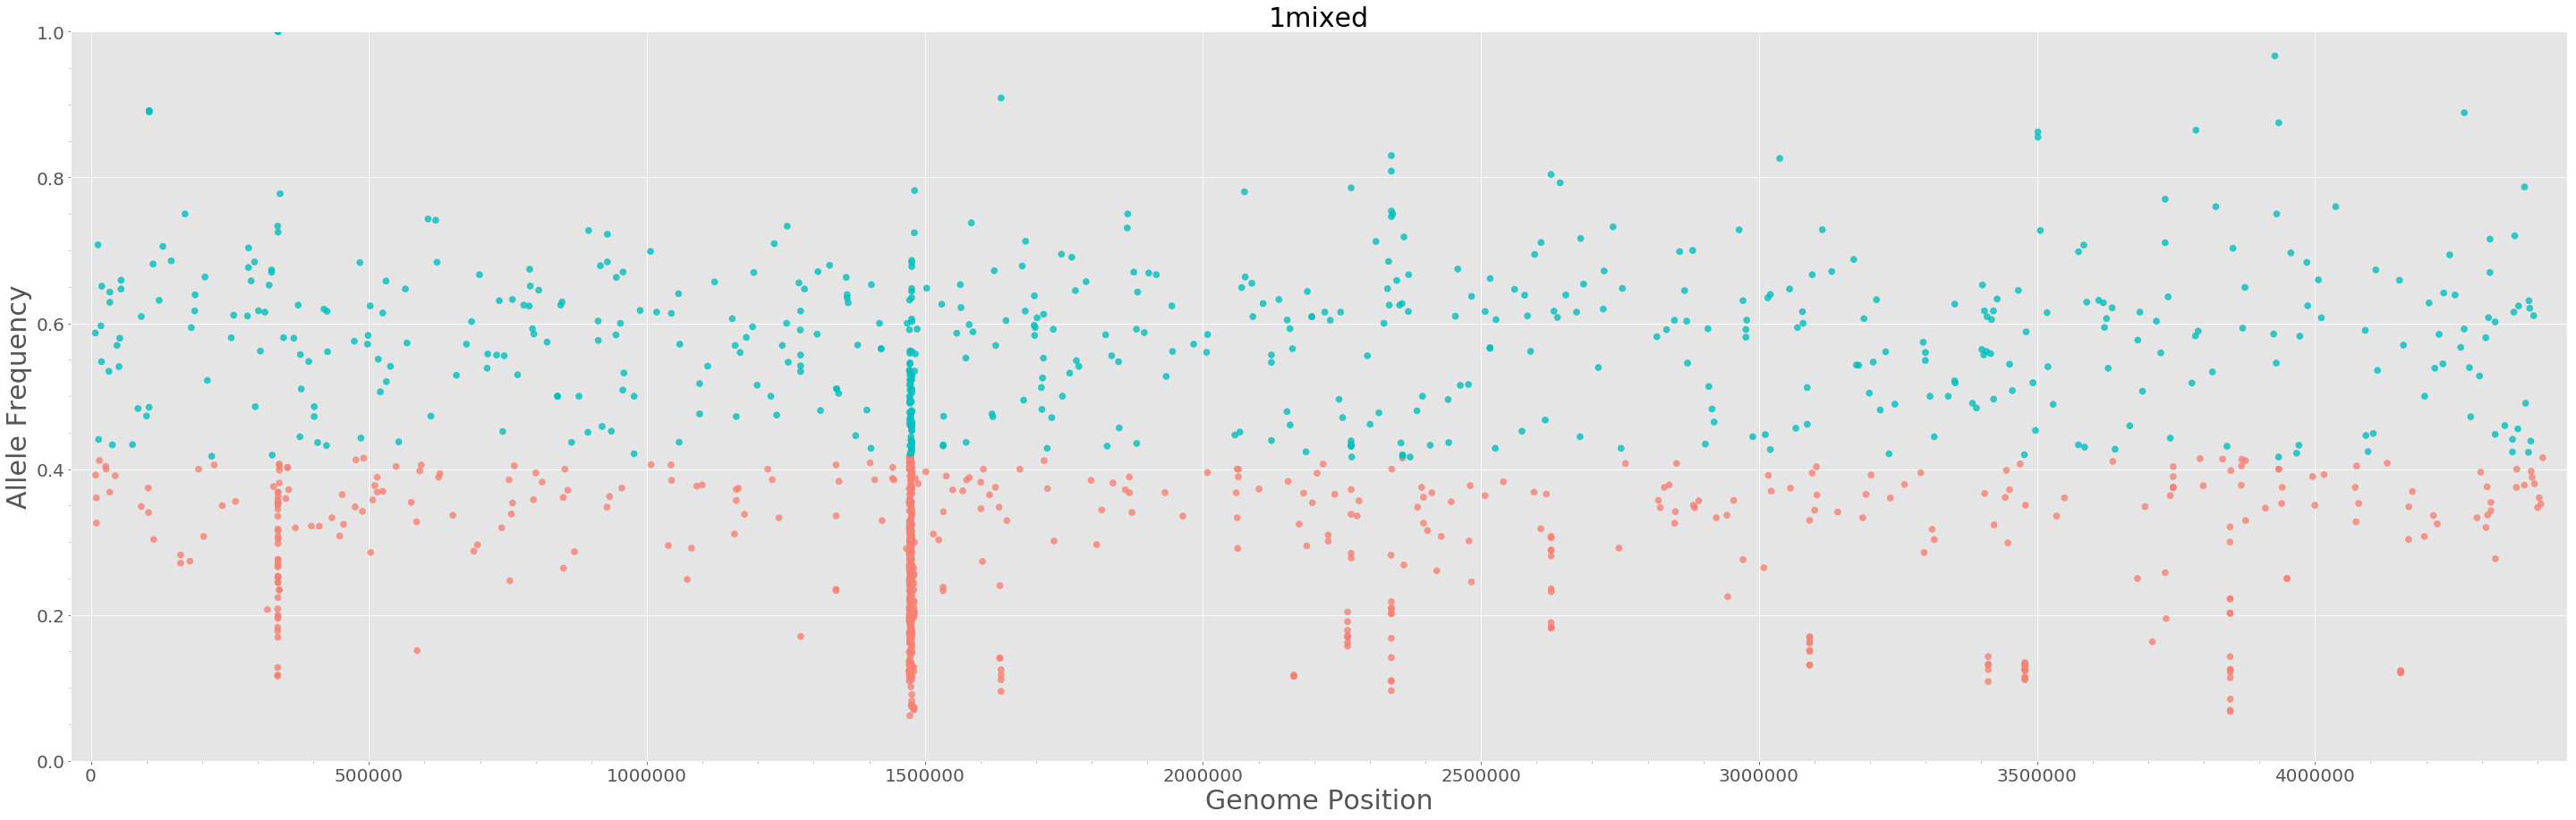

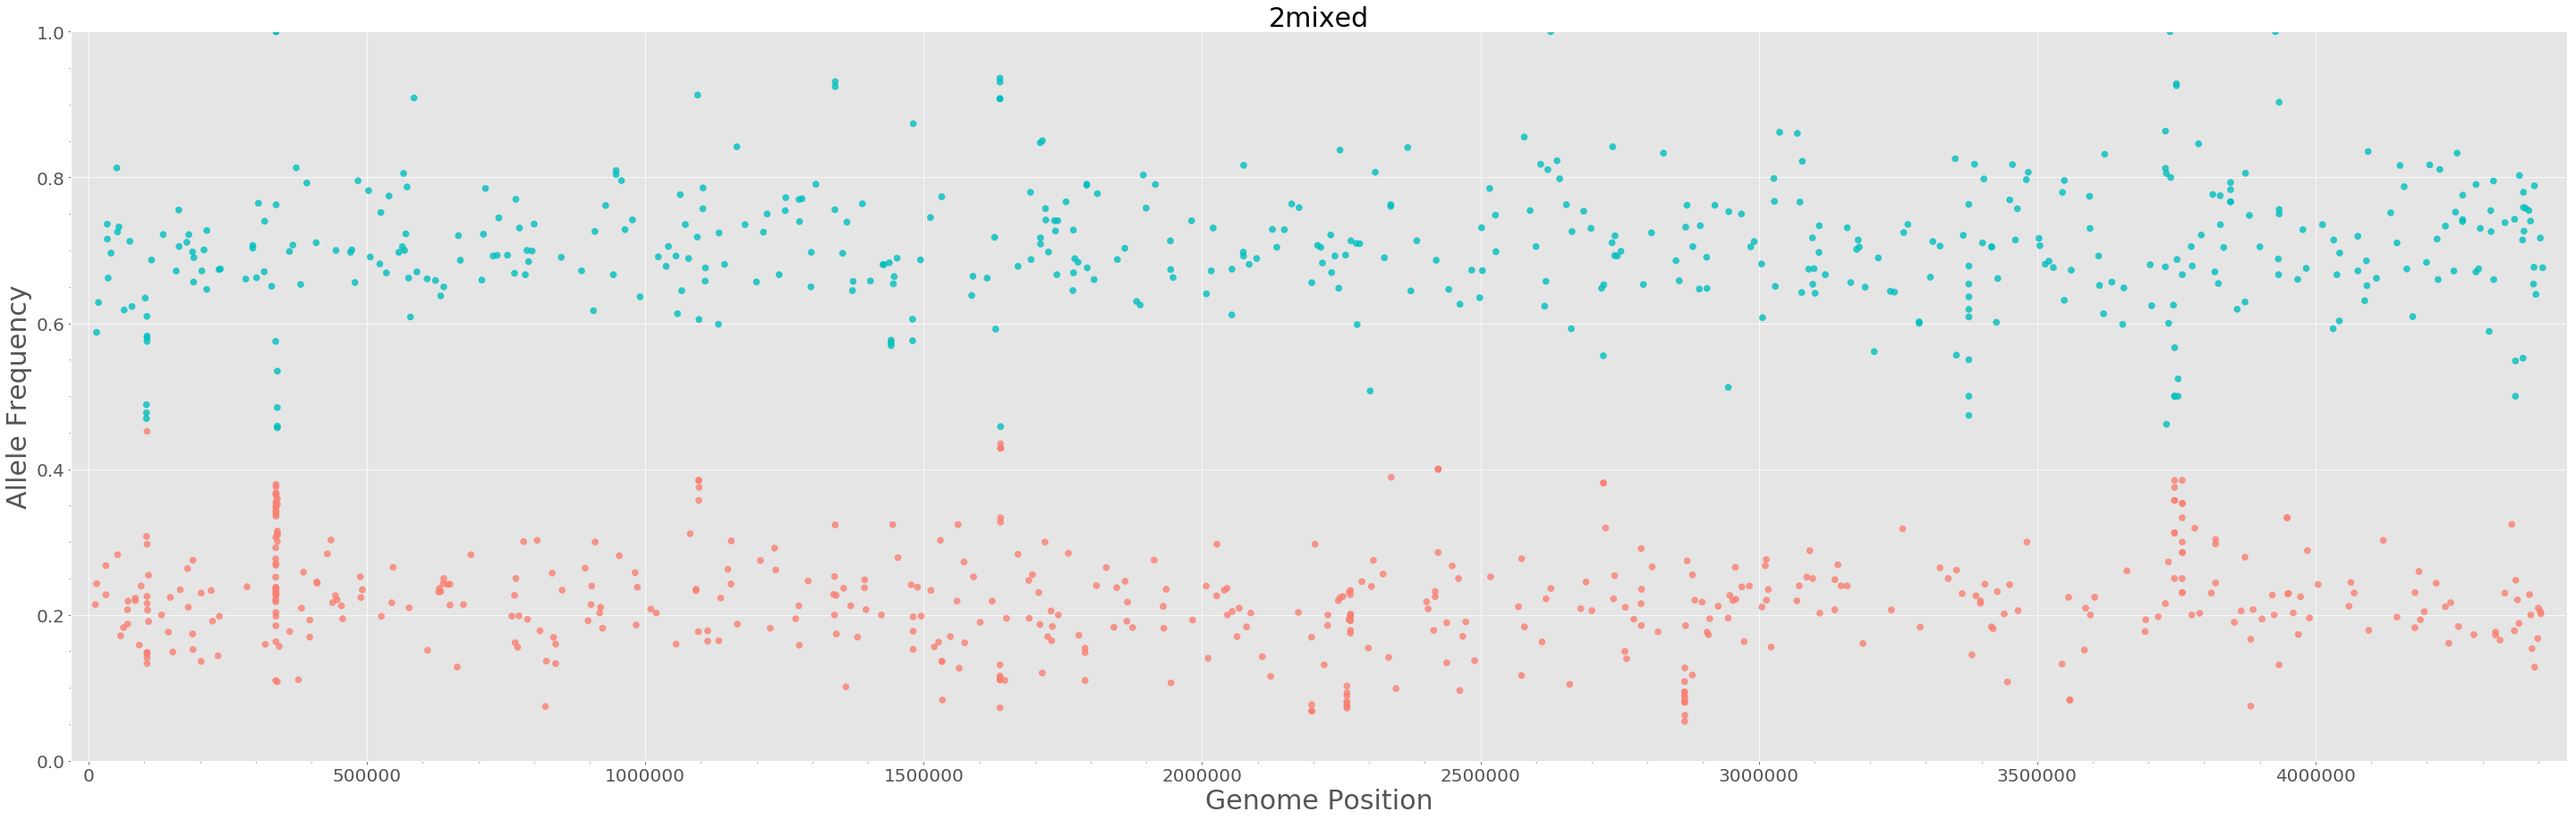

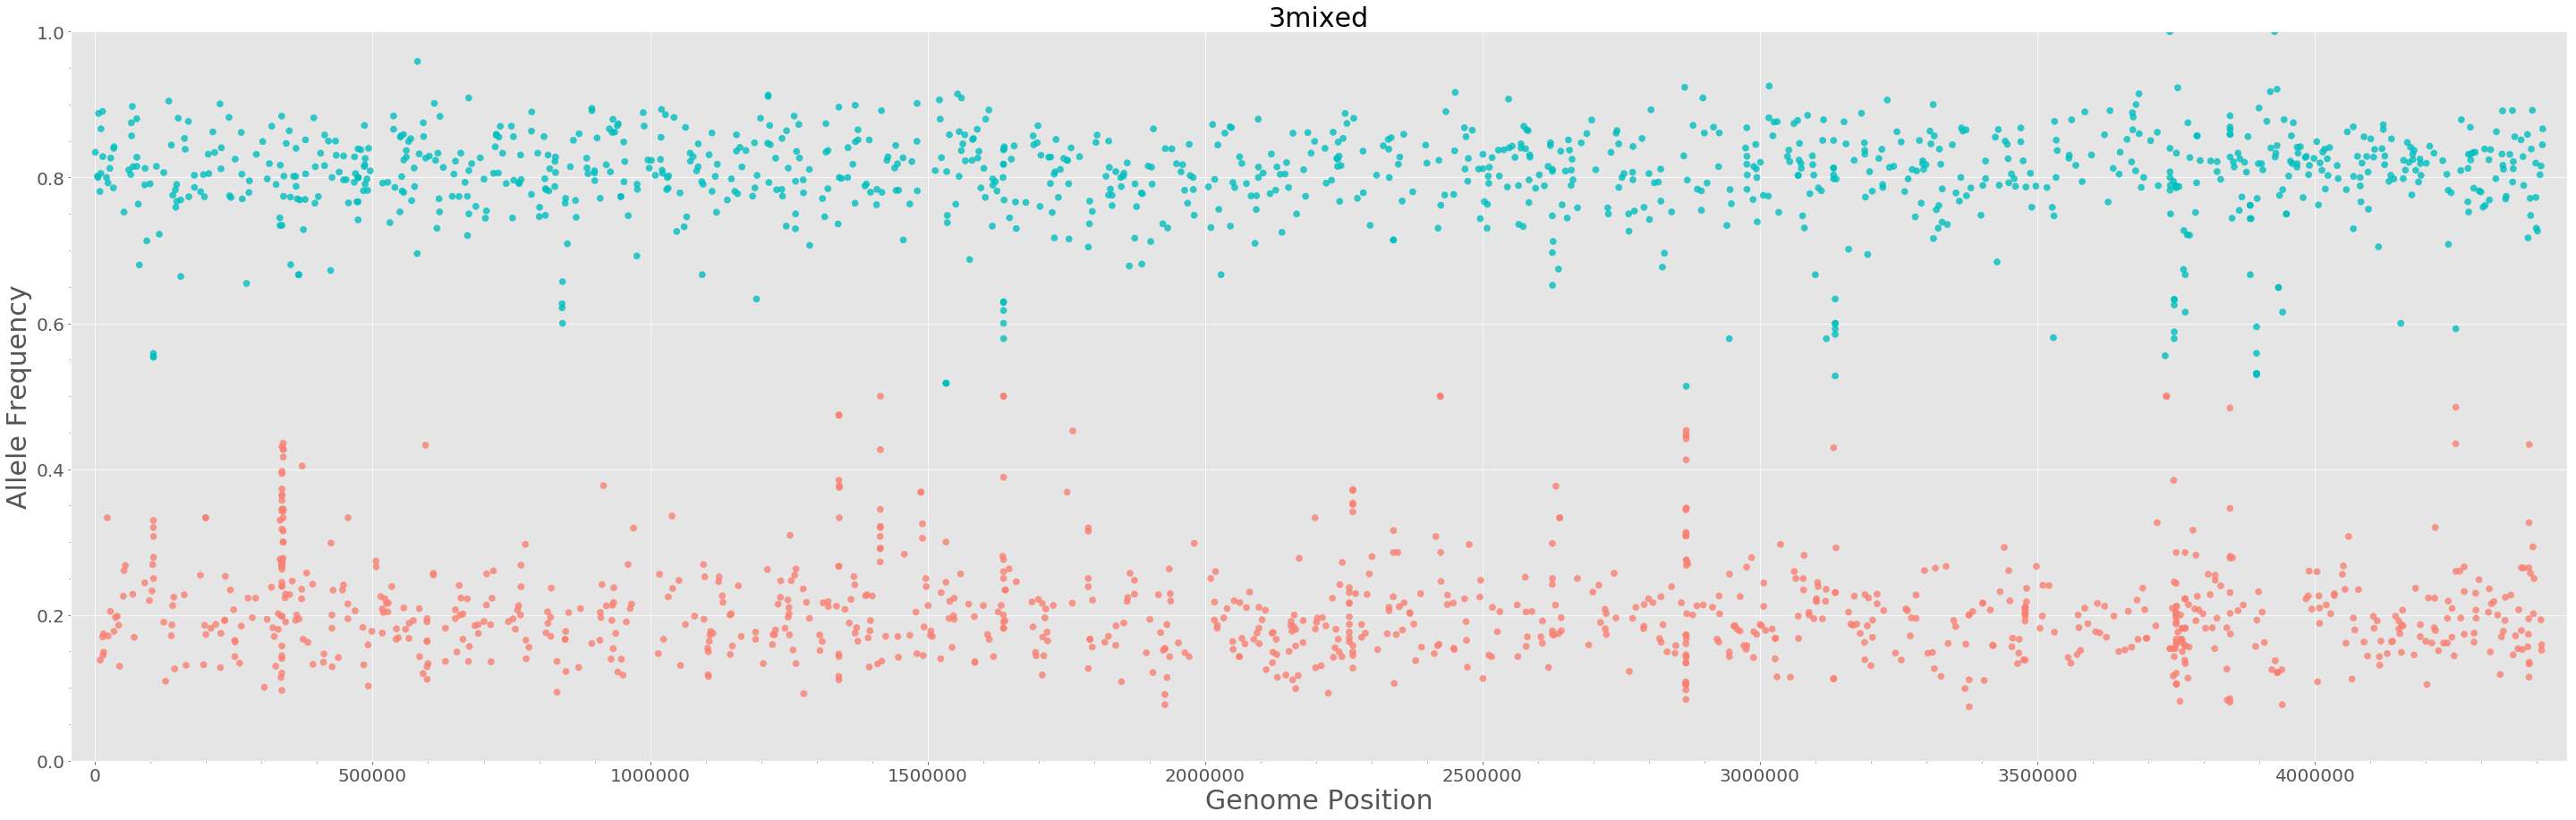

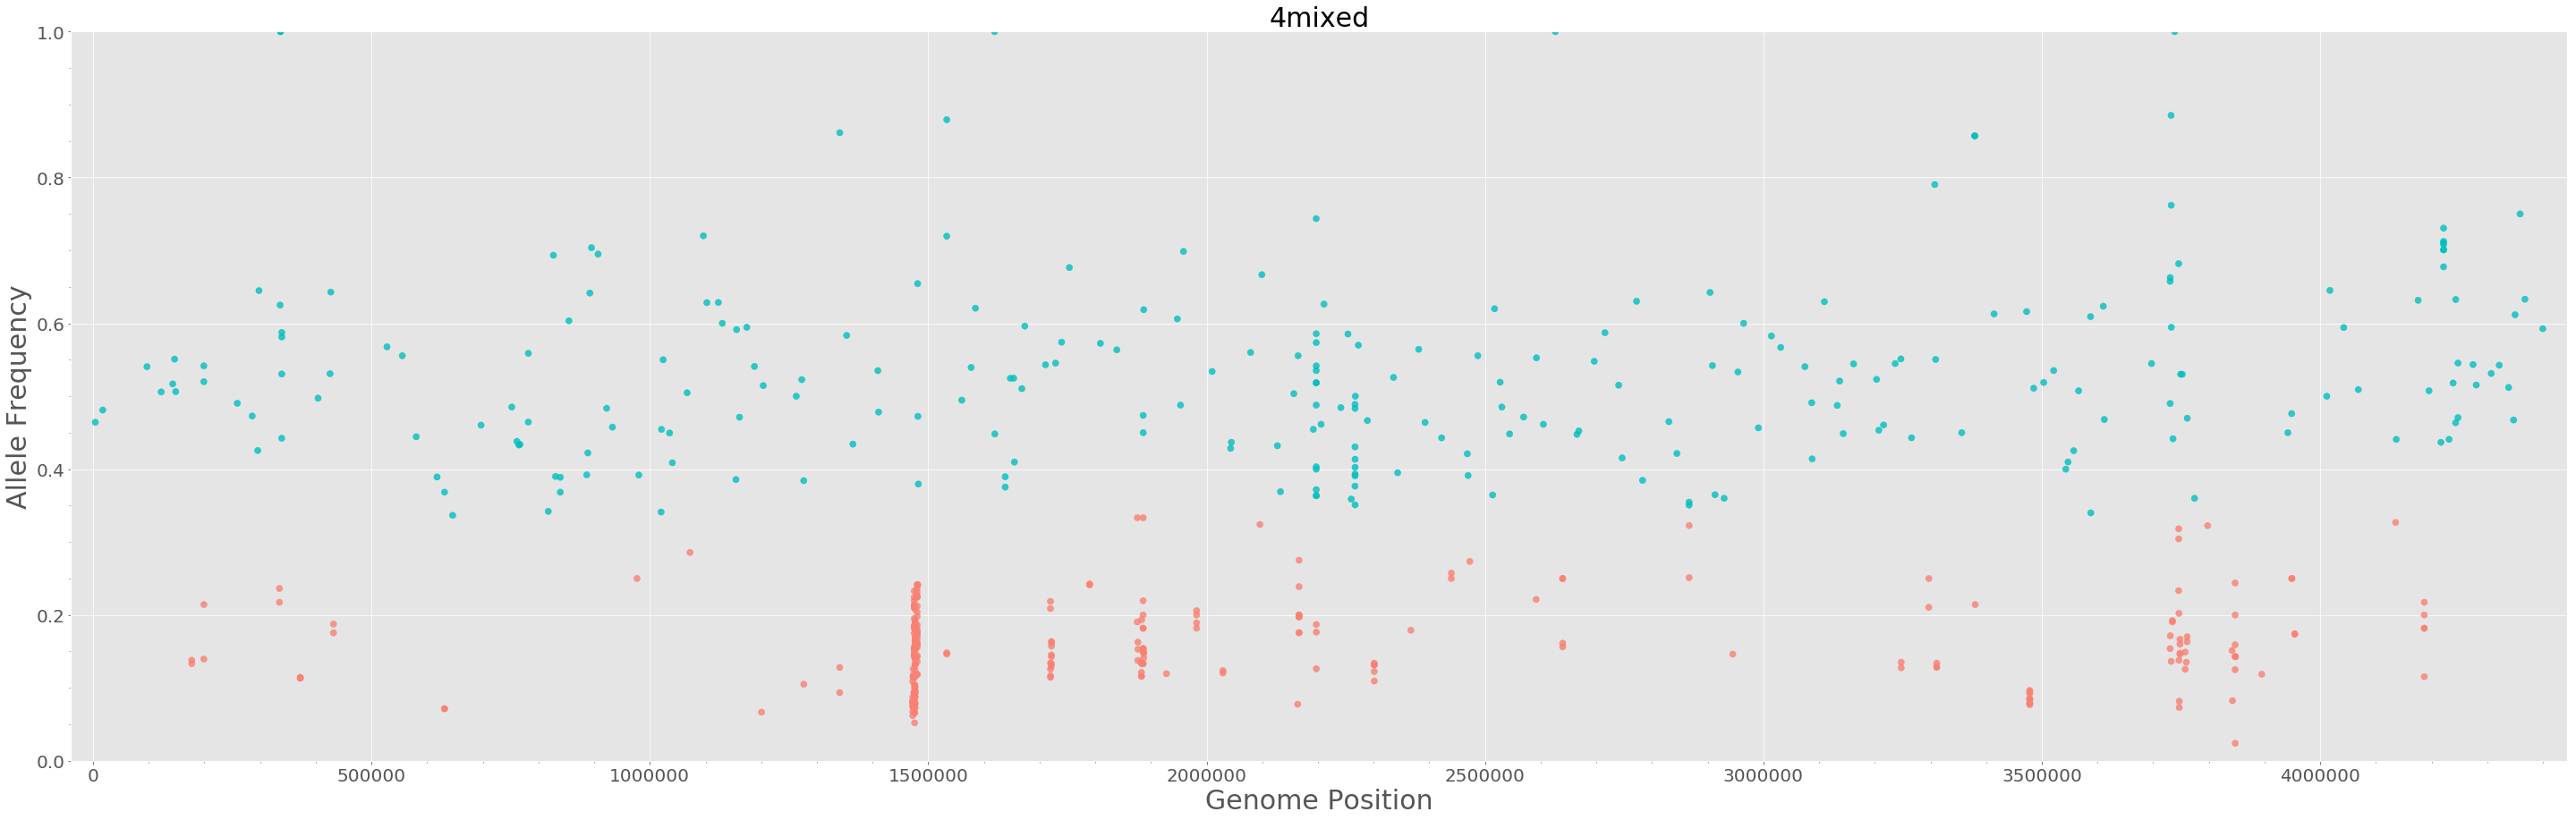

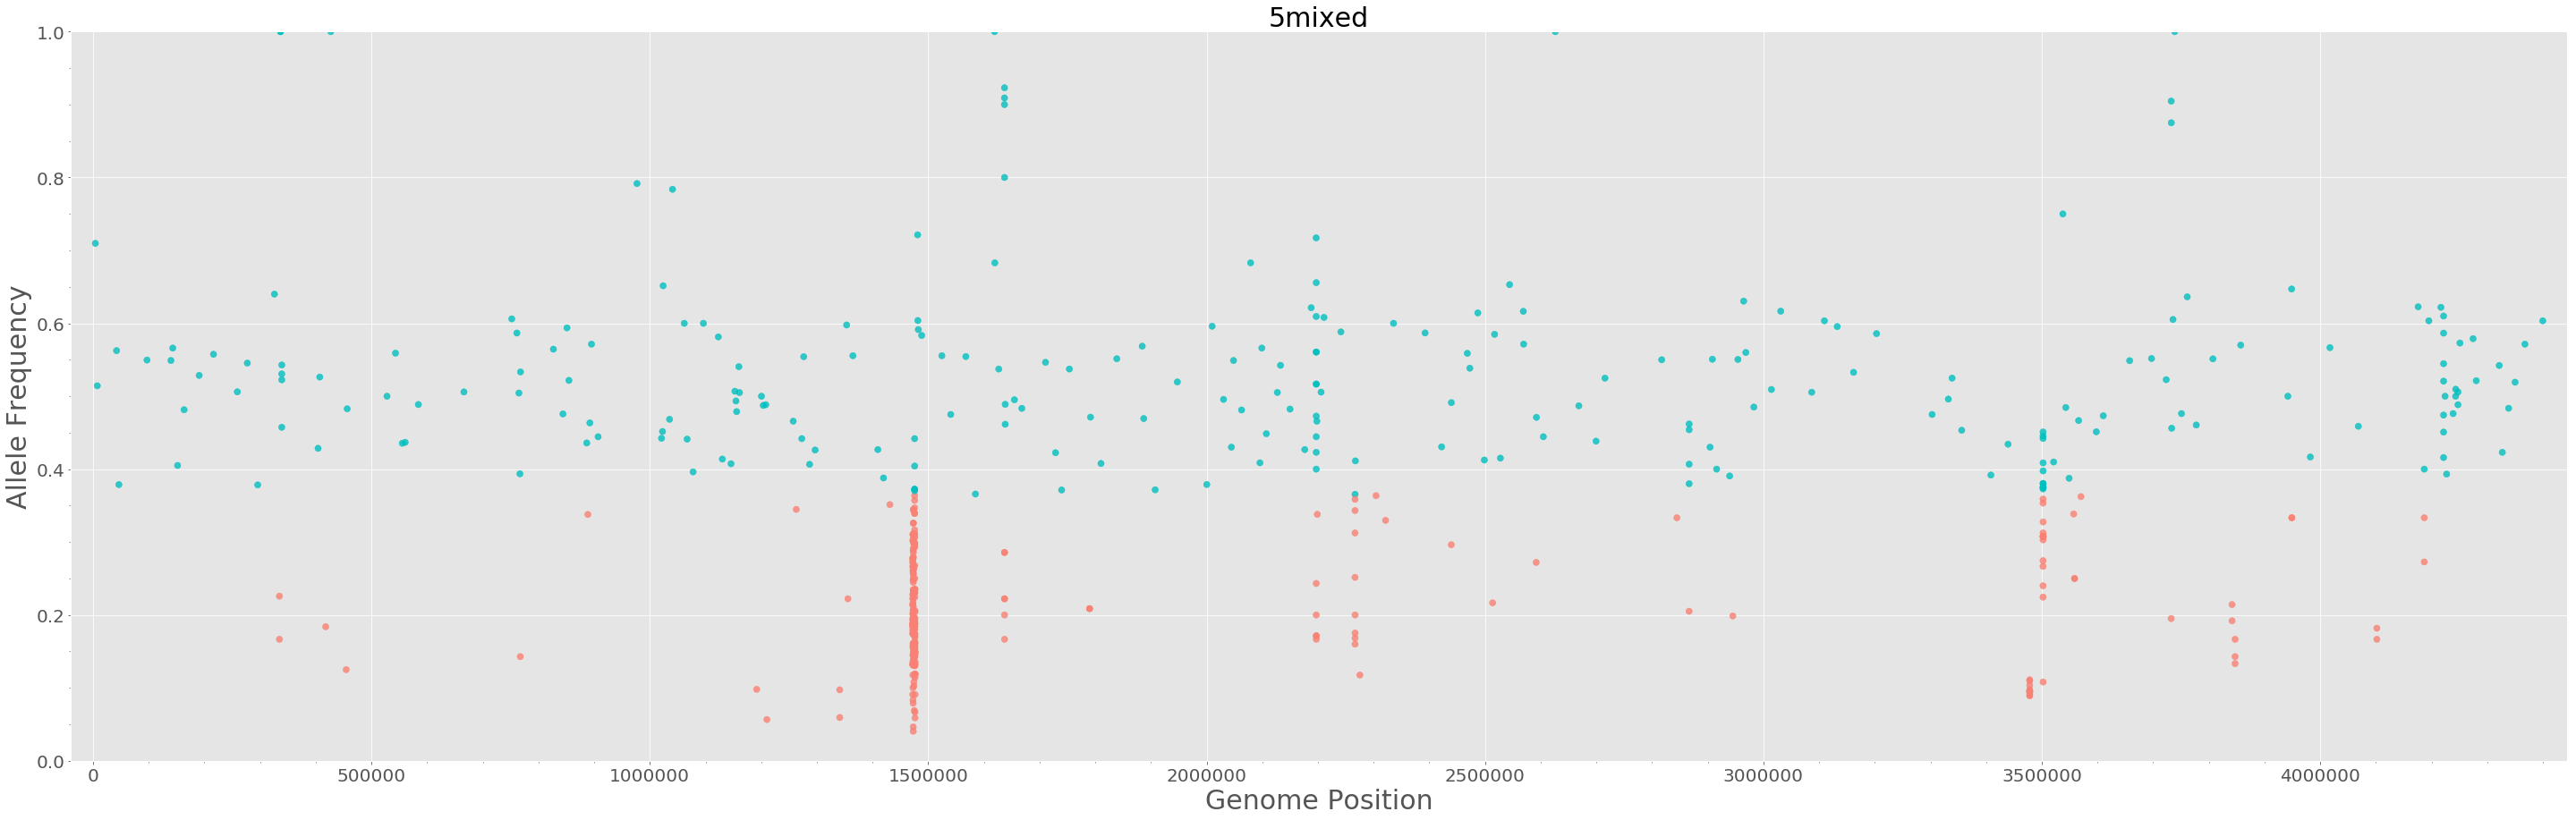

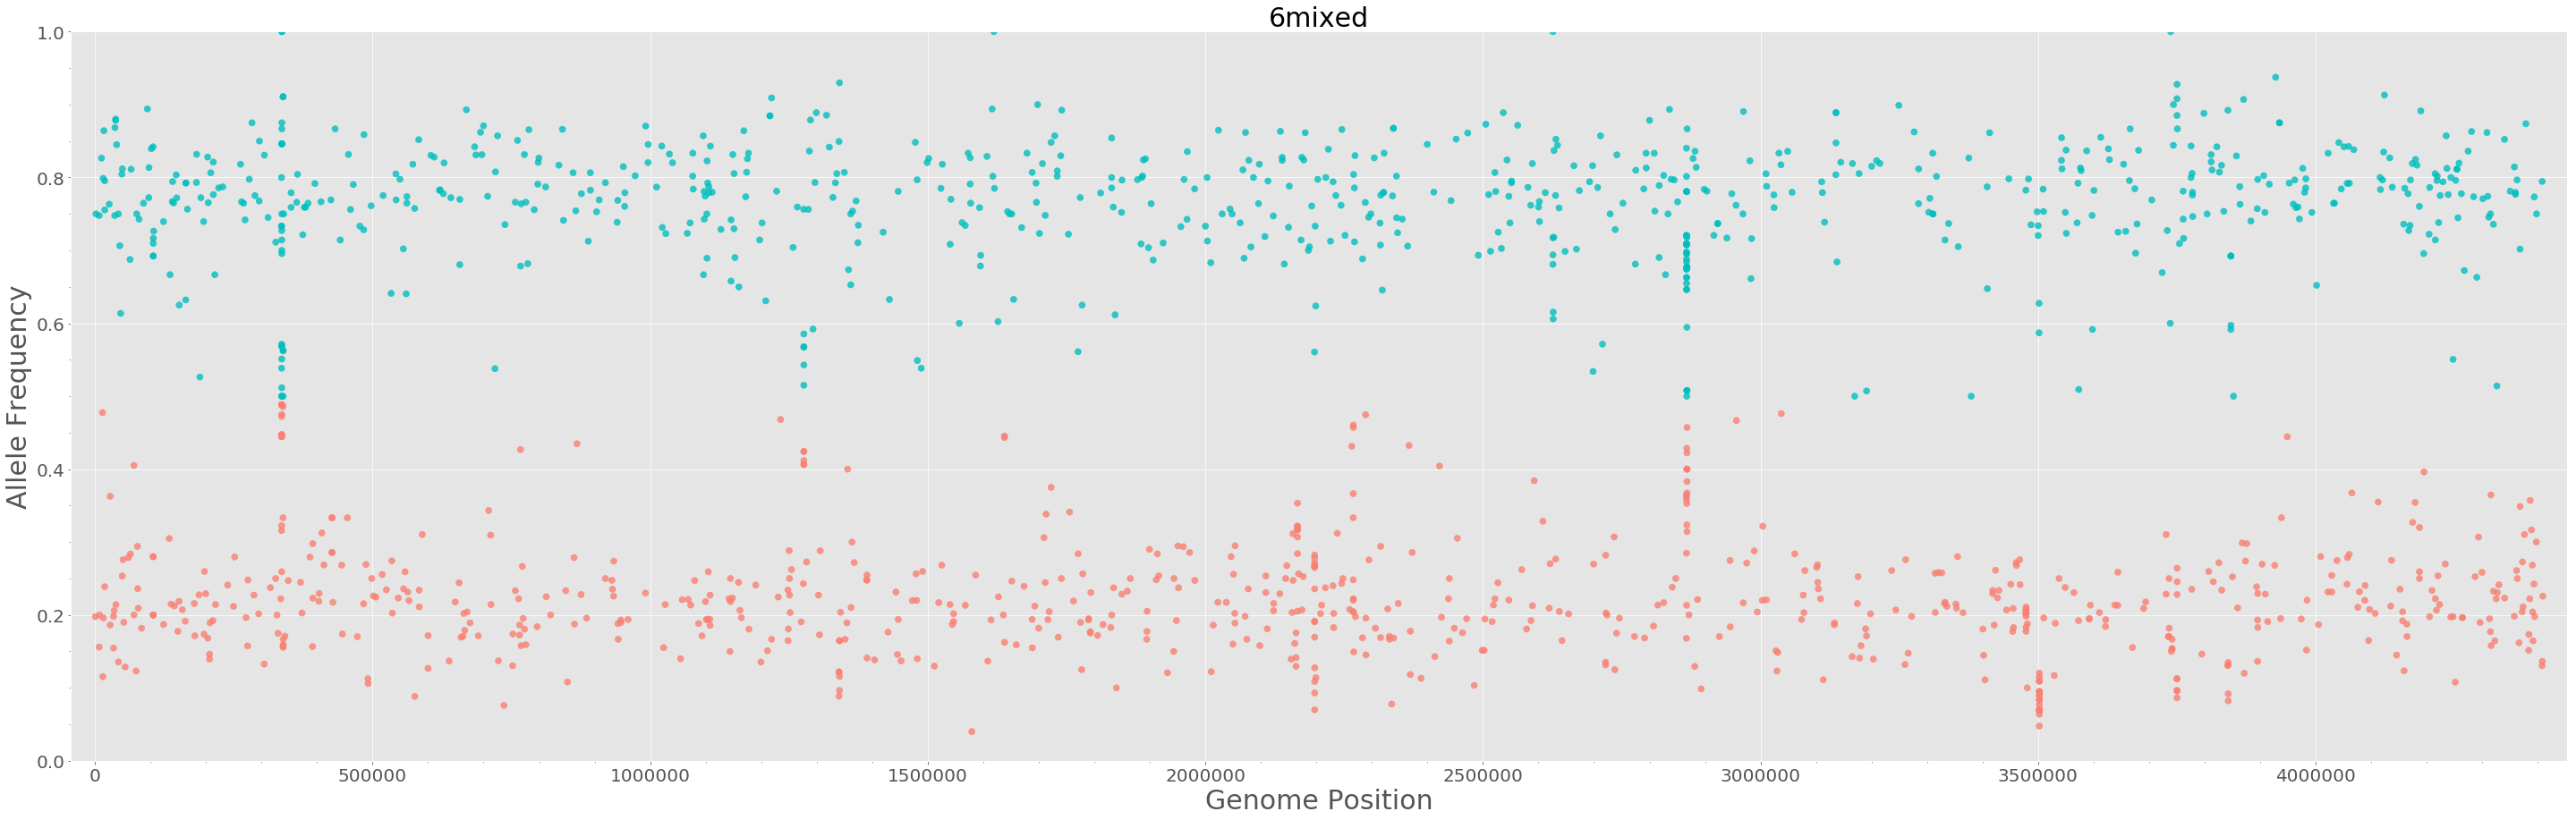

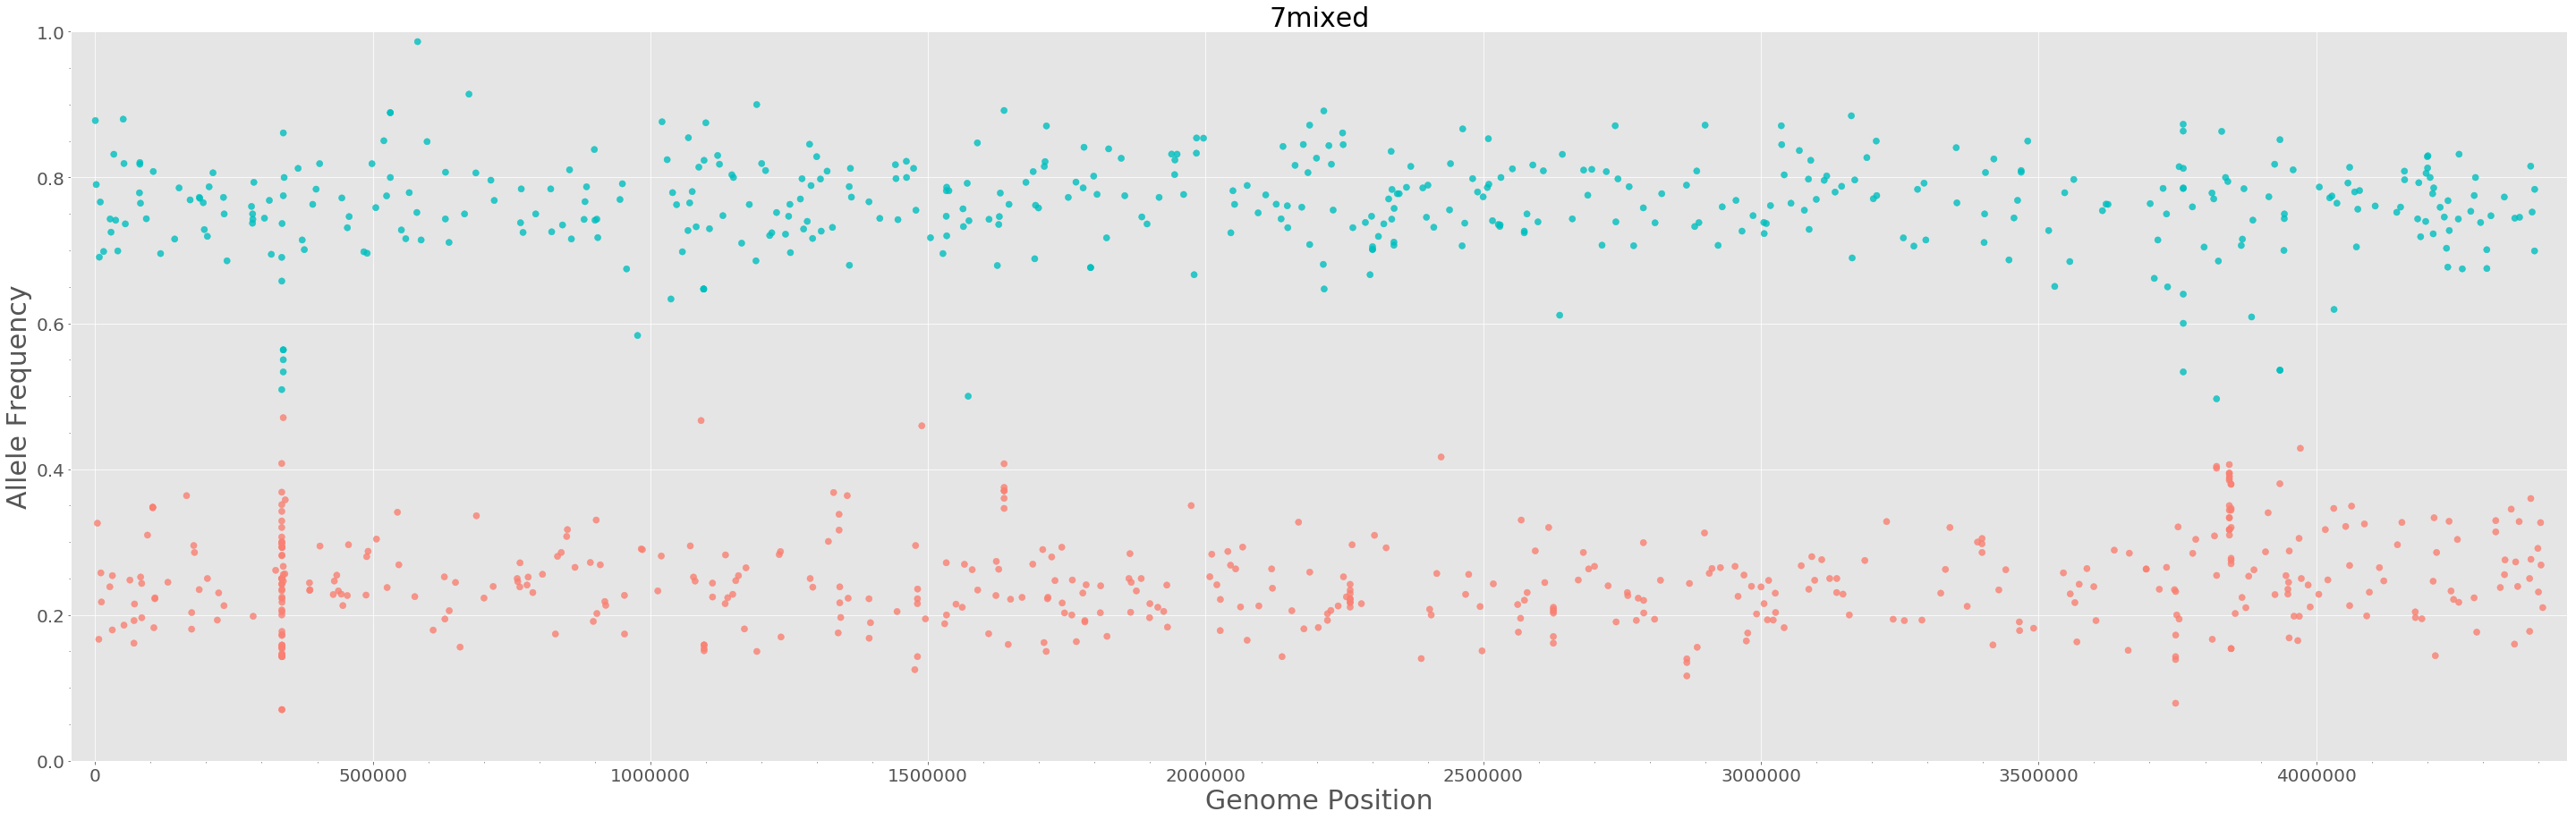

In [54]:
for name_dsf, df in dict_vcf.items():
    scatter_vcf_pos(df,name_dsf)

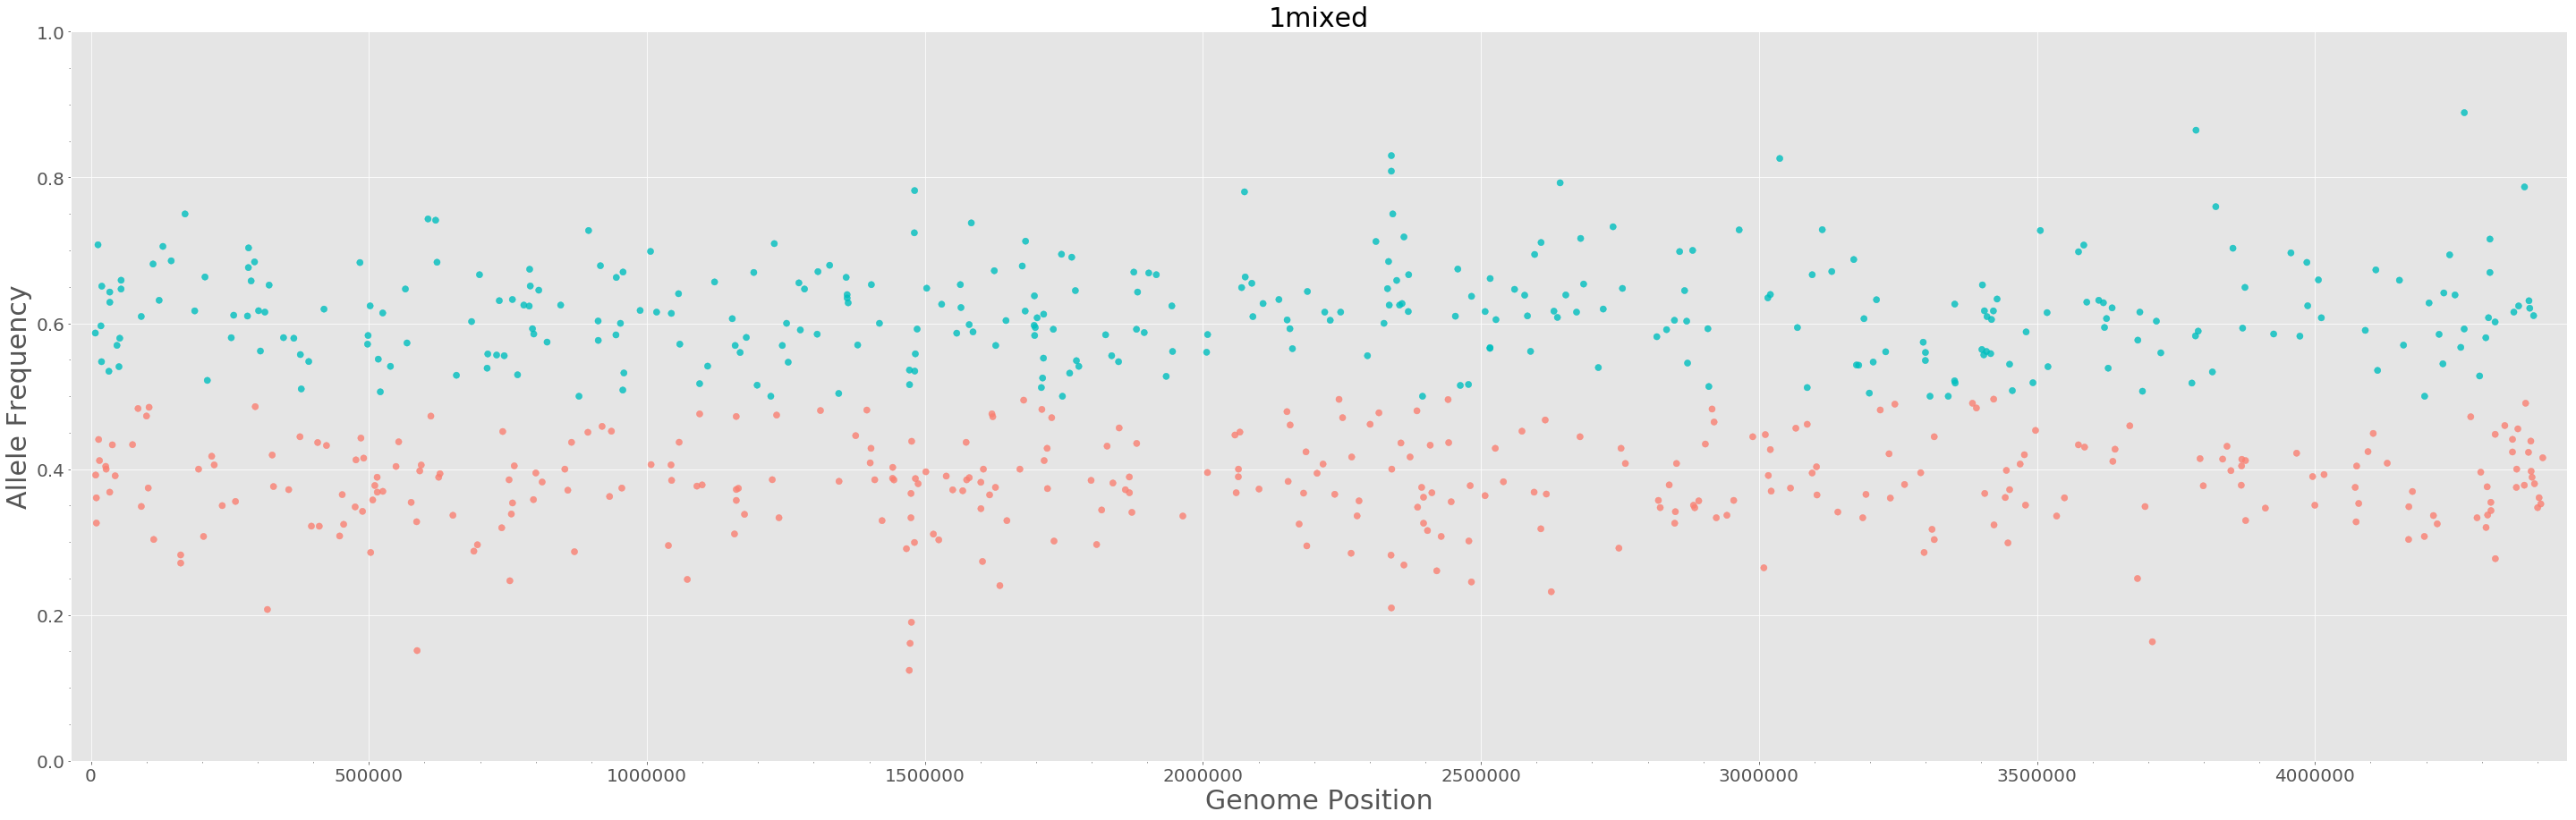

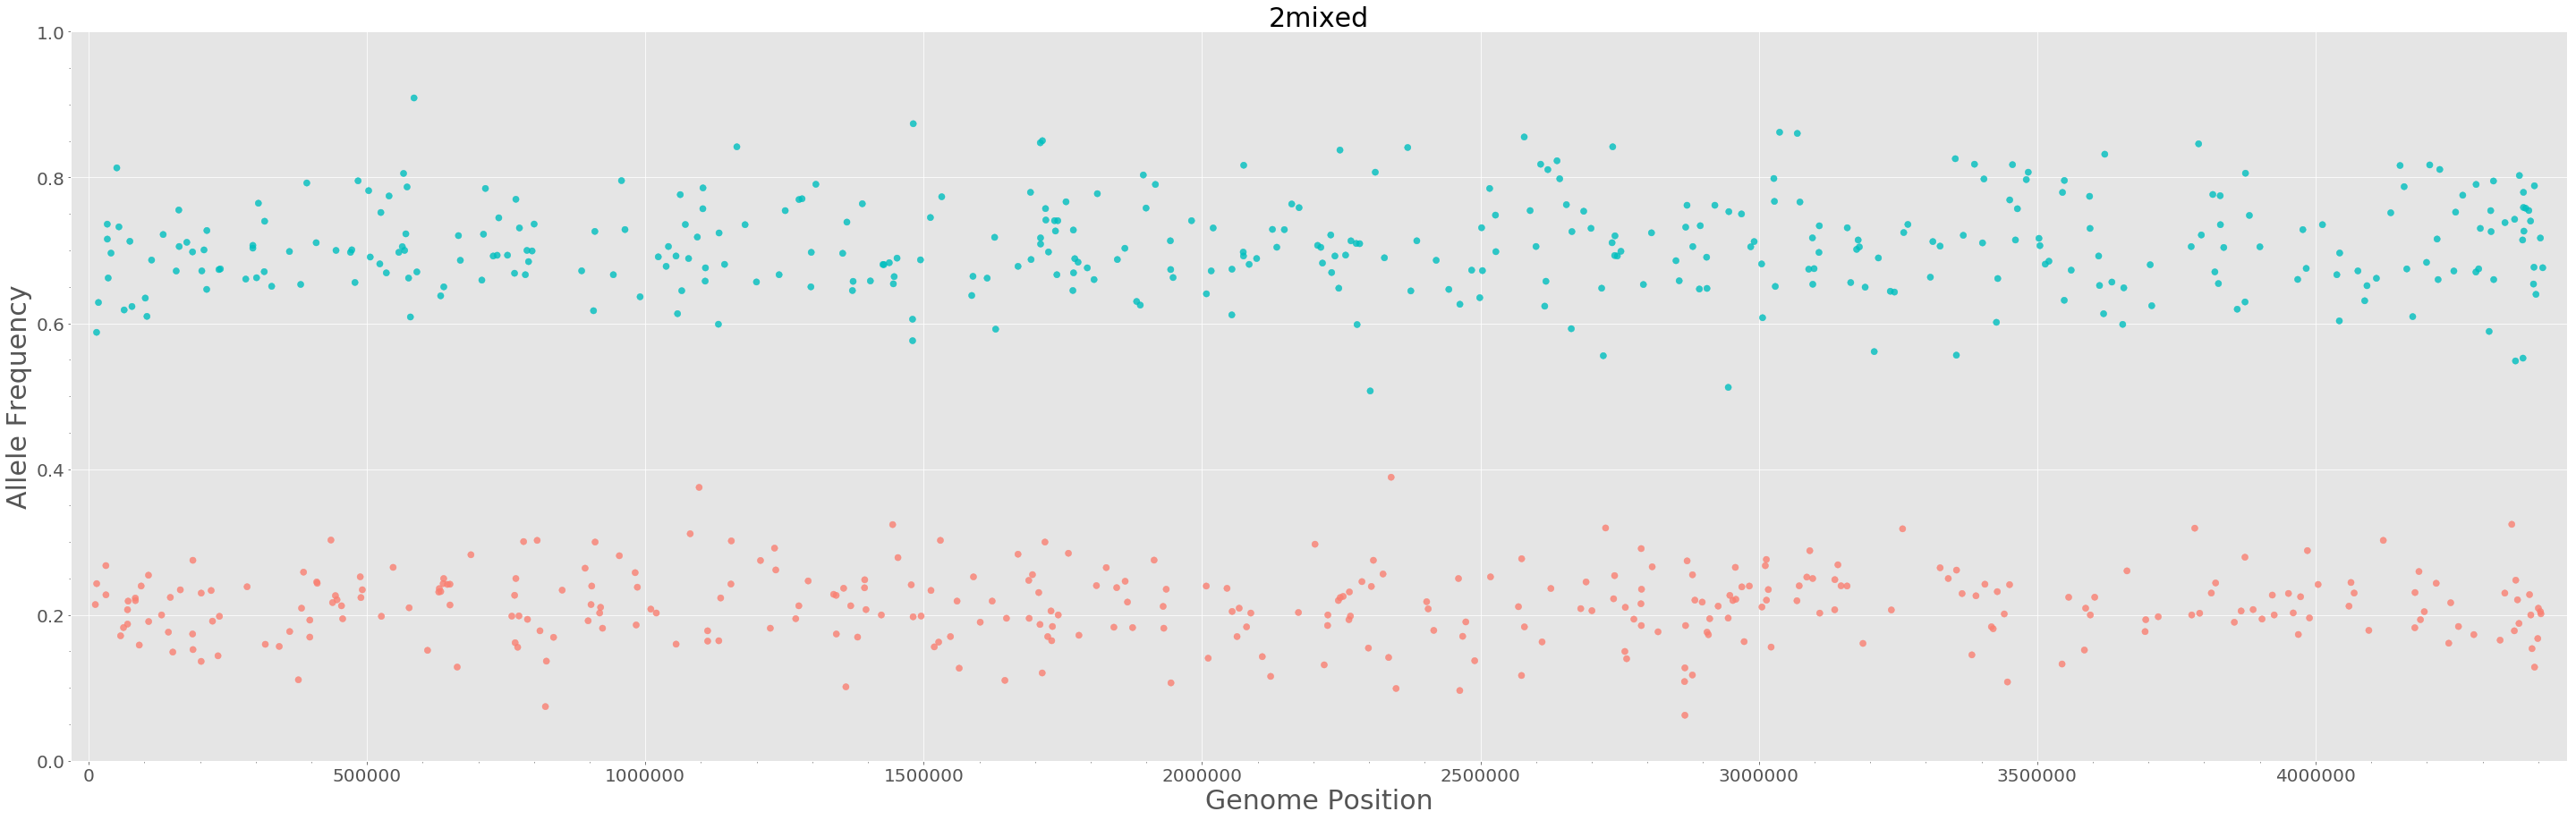

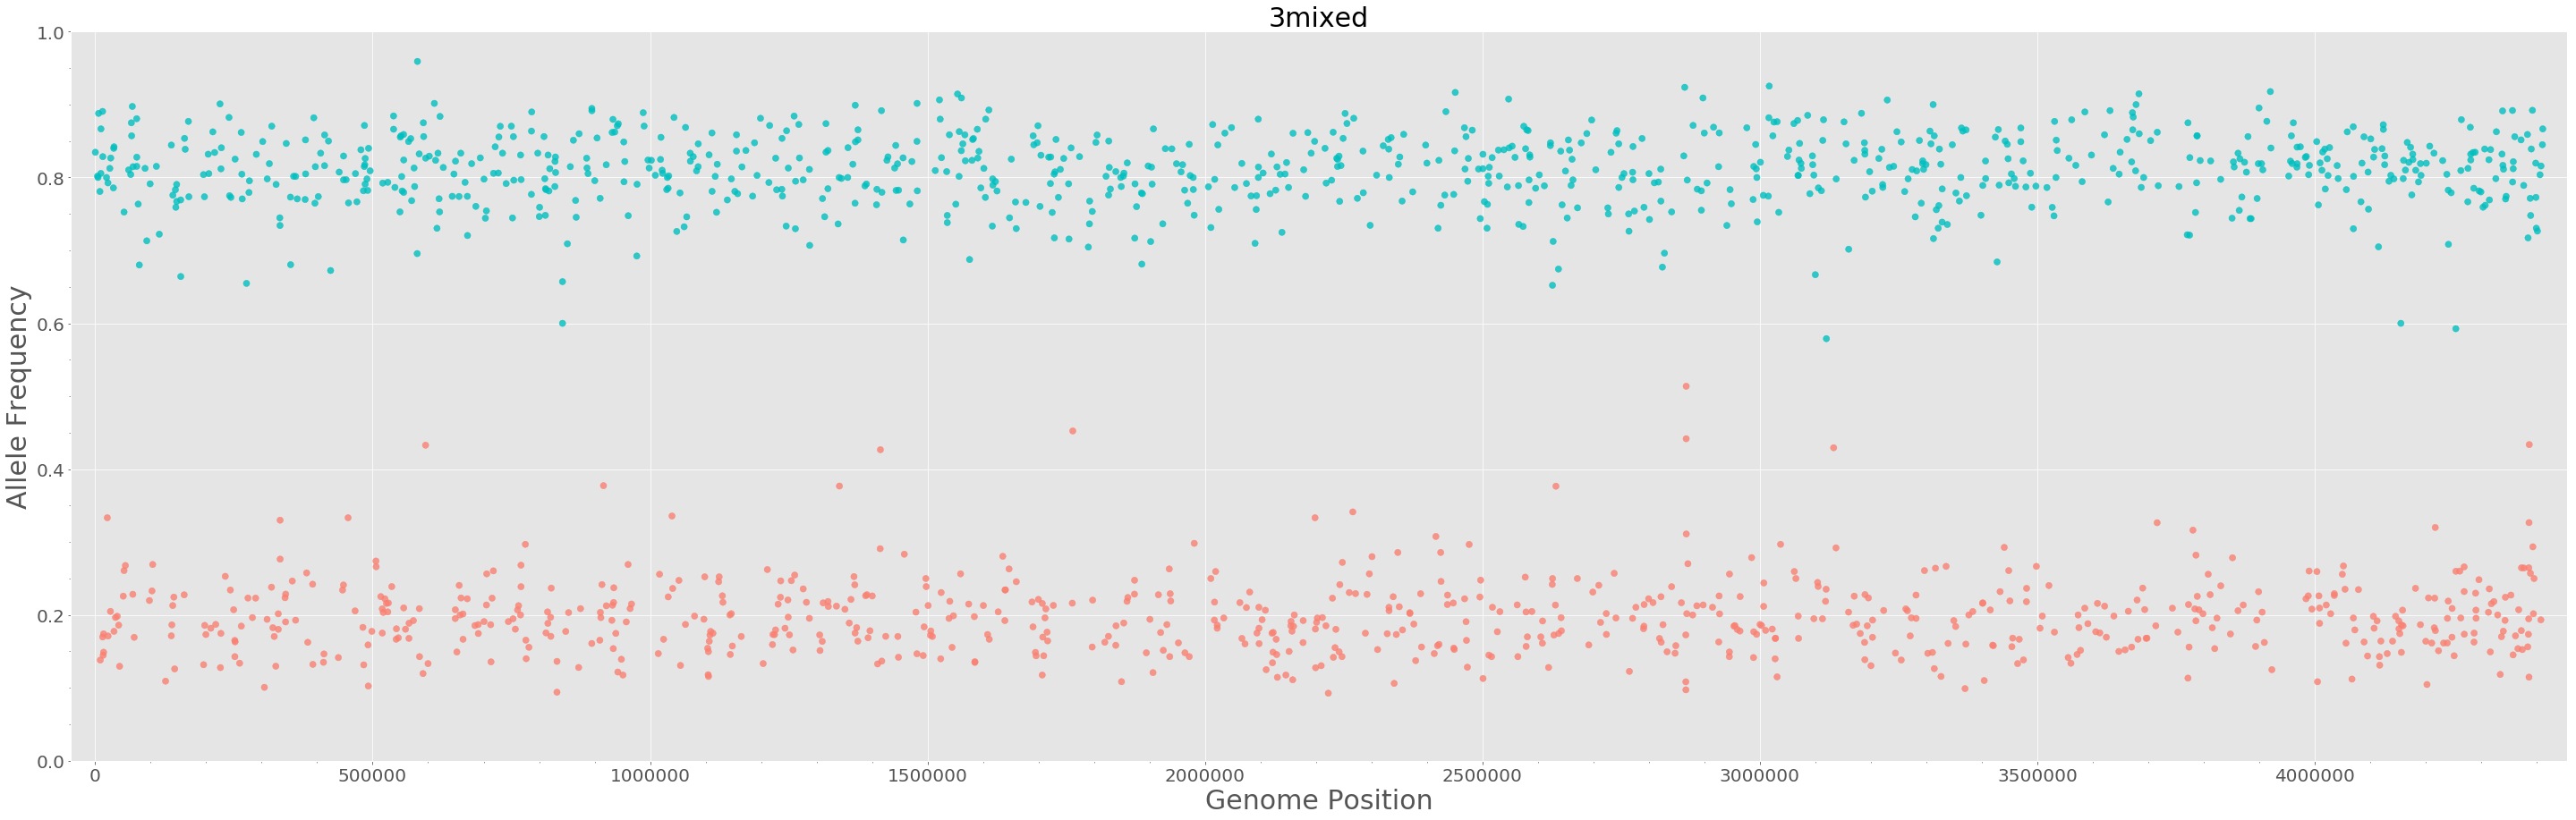

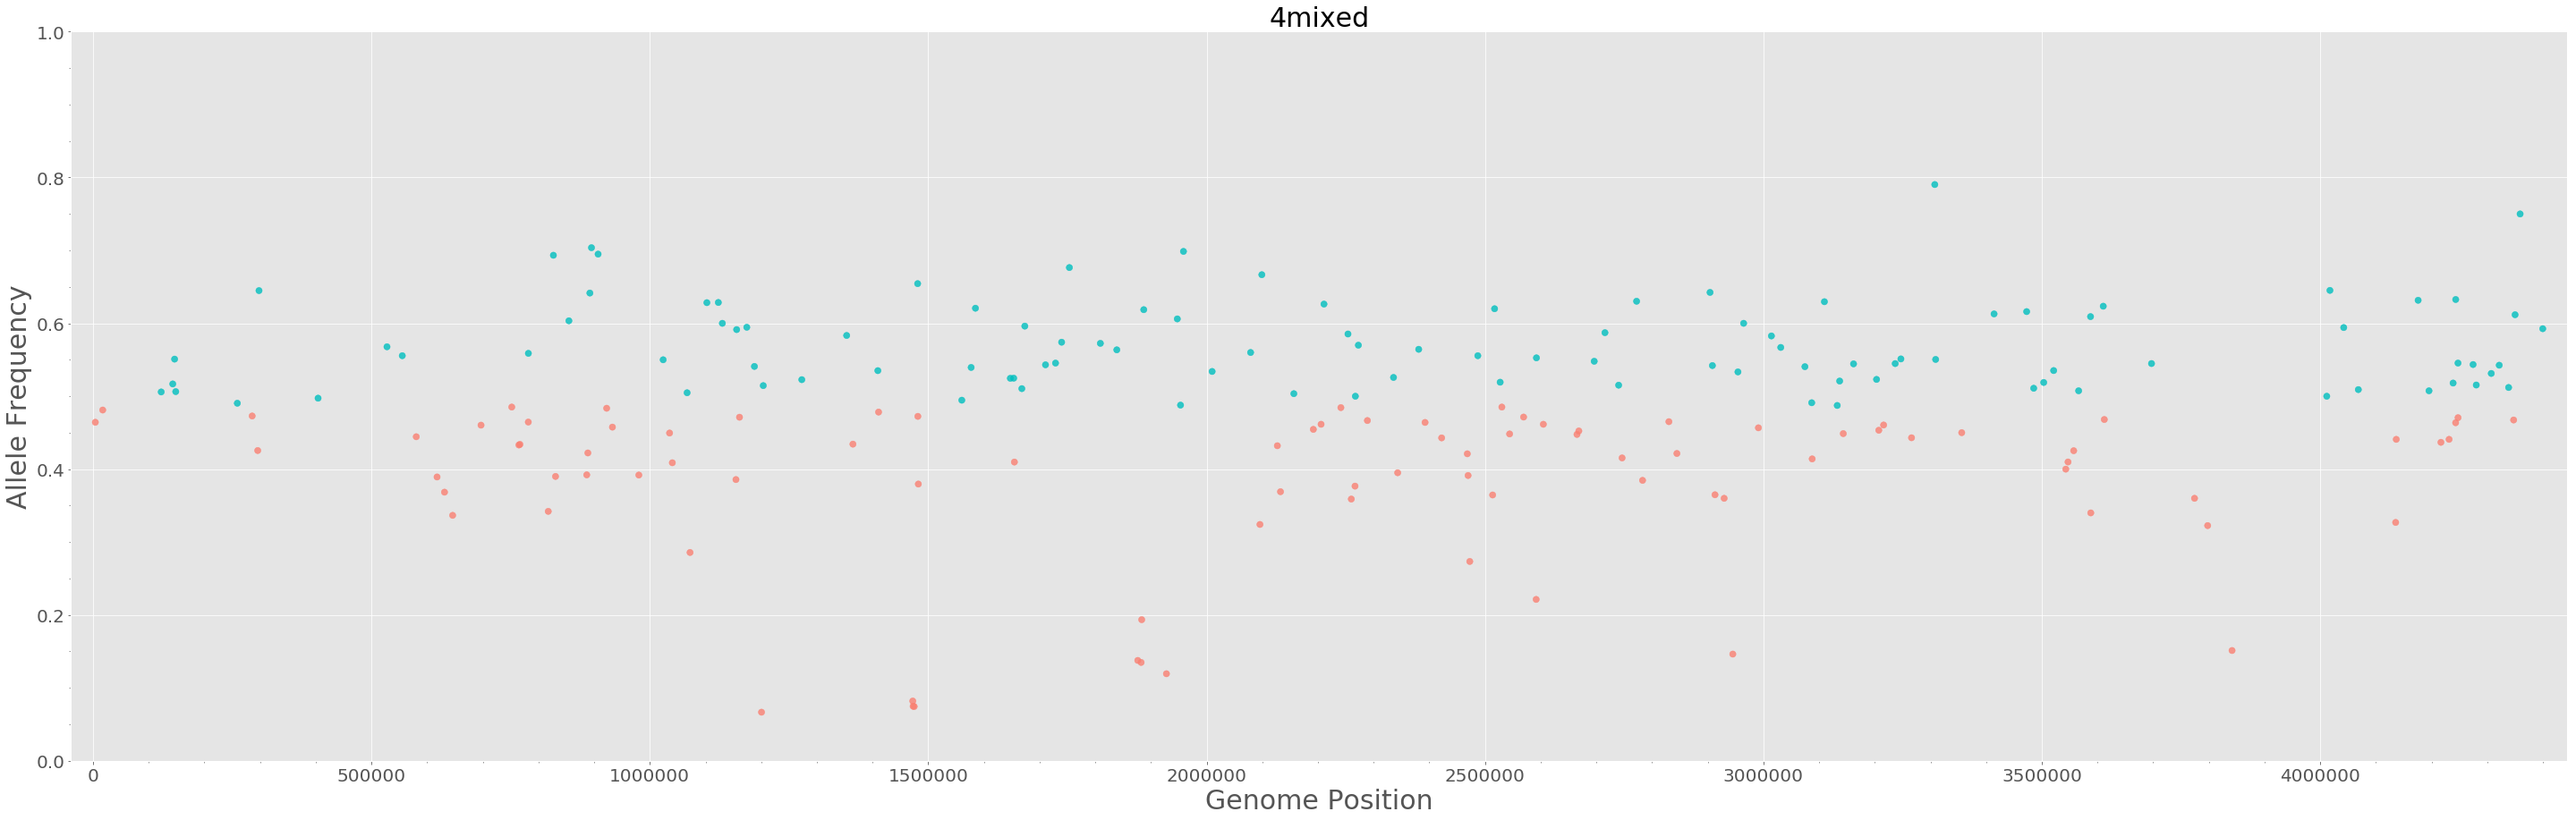

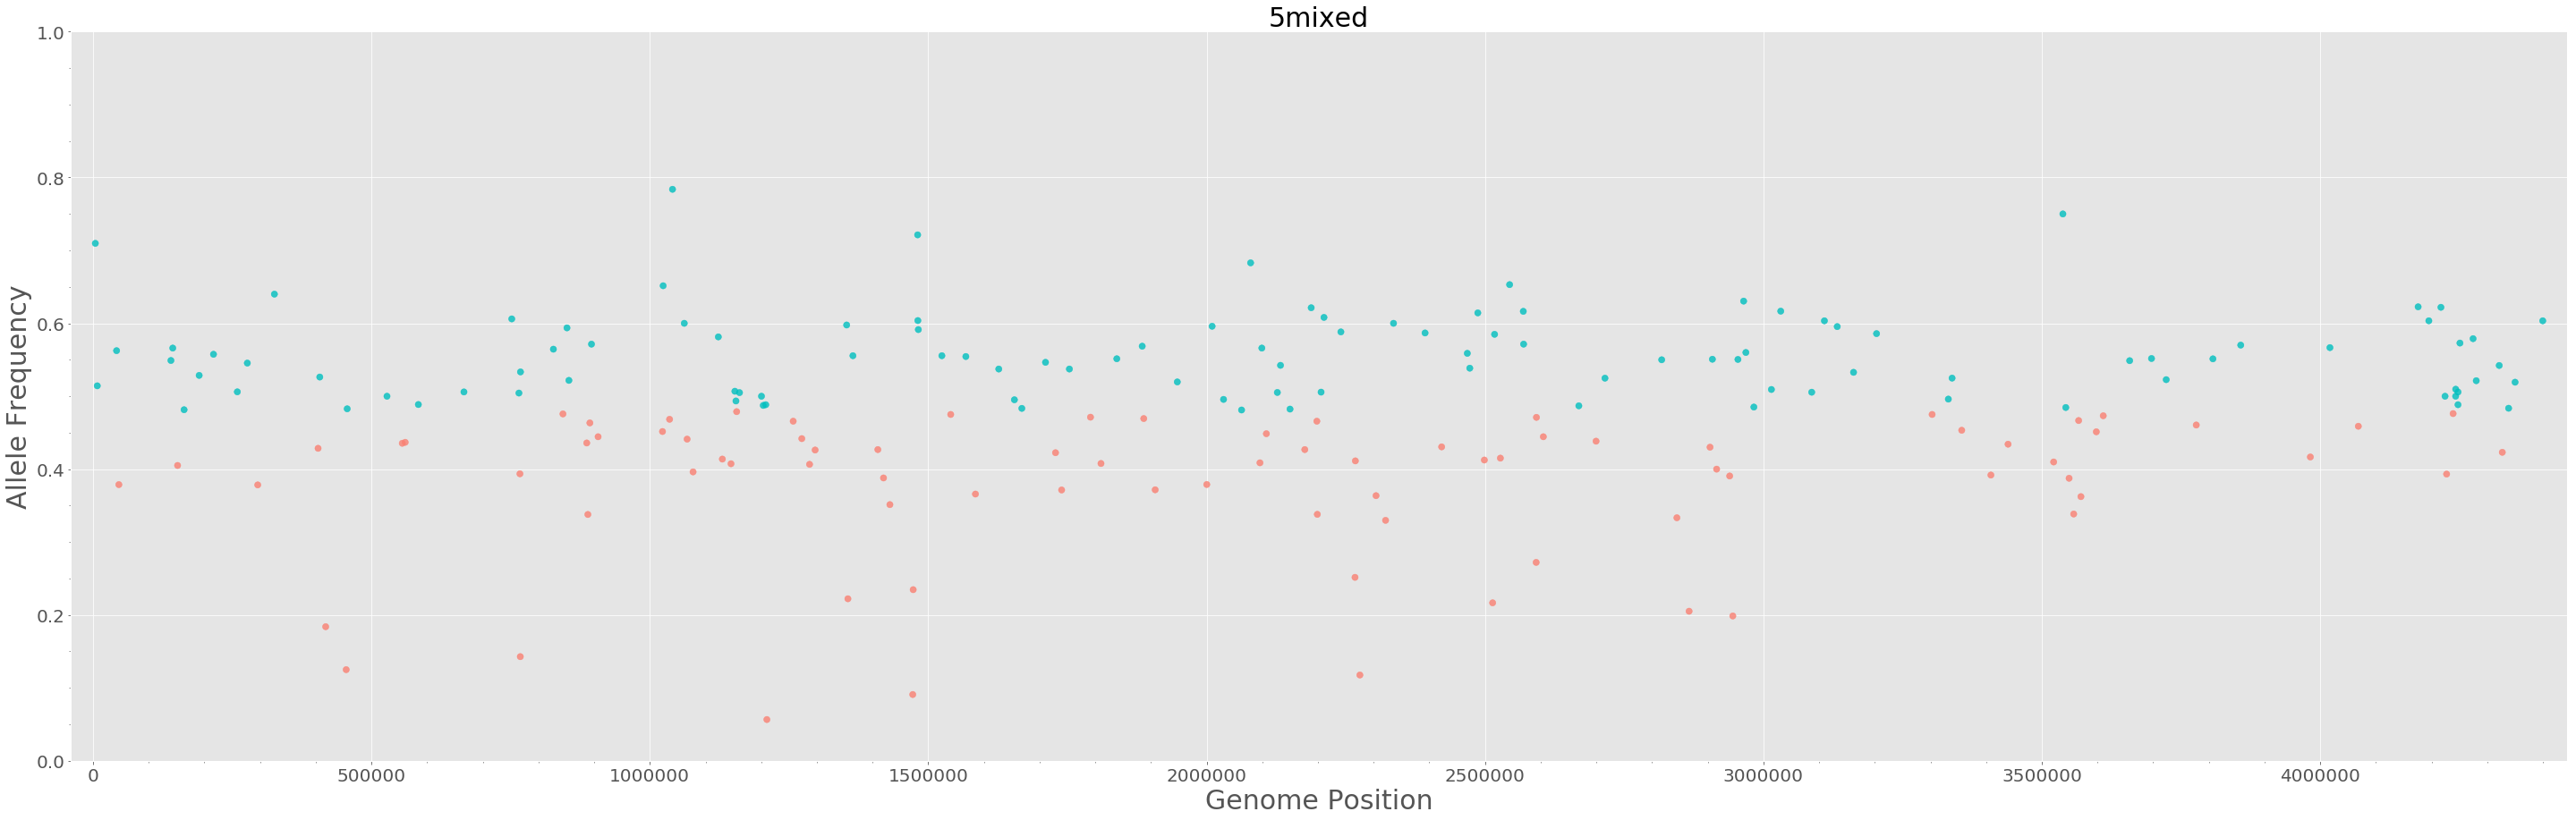

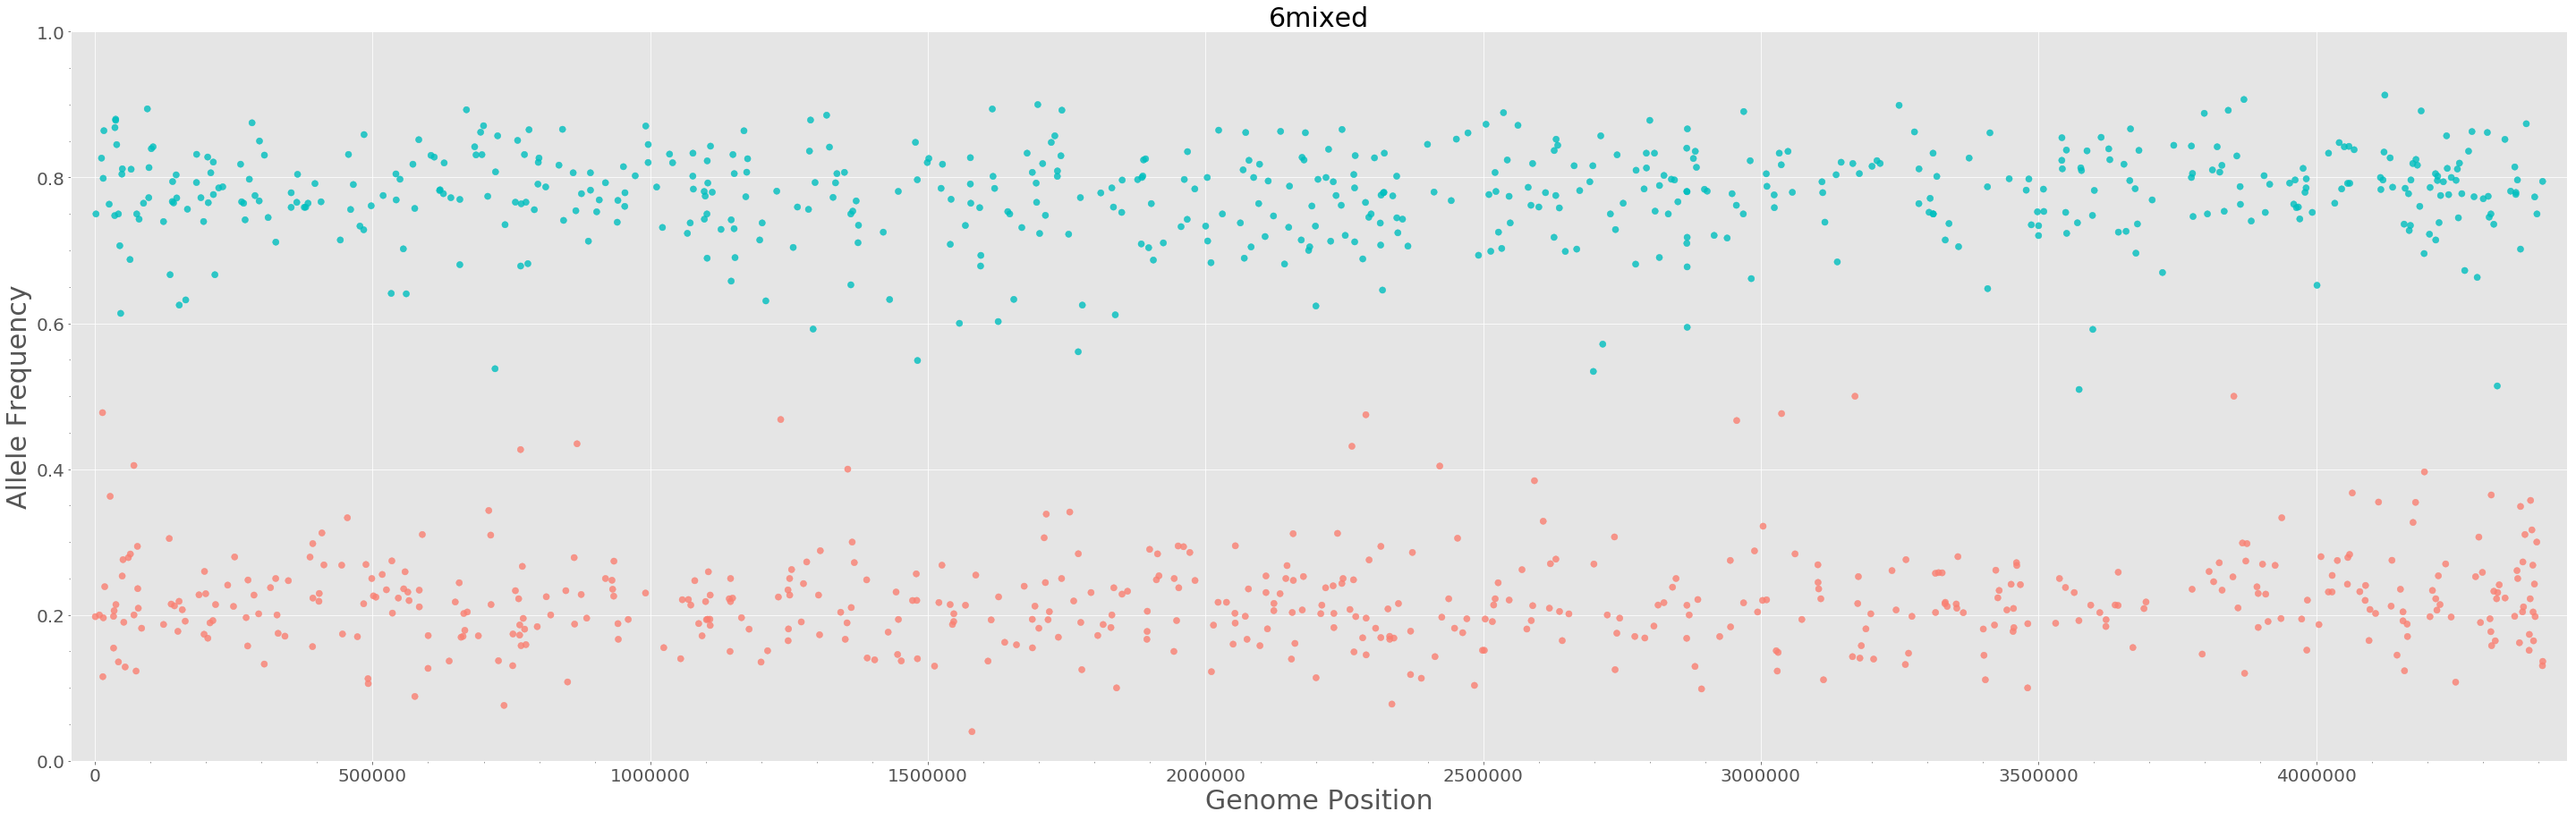

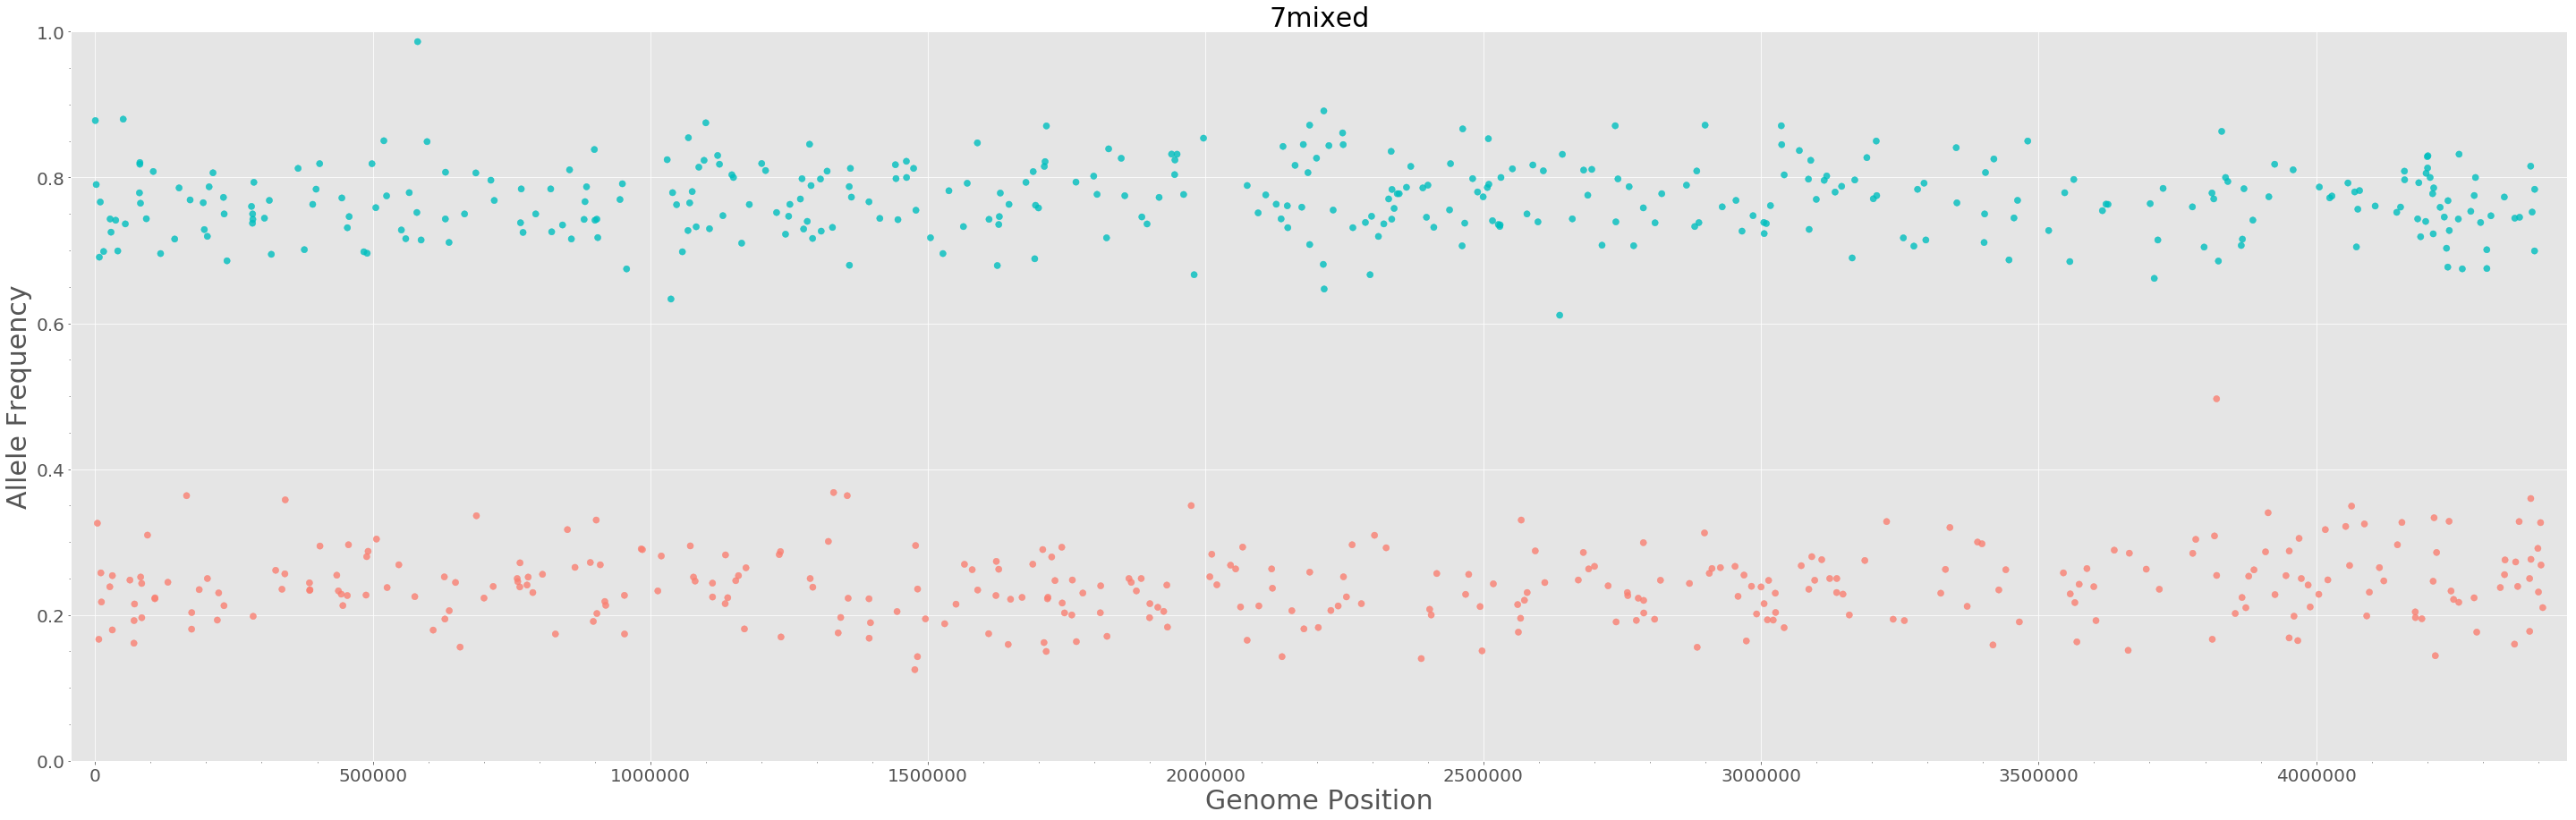

In [96]:
for name_dsf, df in dict_dff.items():
    scatter_vcf_pos(df,name_dsf)

In [56]:
mix6 = dict_dff['6mixed']
mix6[(mix6.AF > 0.4) & (mix6.AF < 0.6)]

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample,AC,af,AN,BaseQRankSum,DP,ExcessHet,FS,MQ,MQRankSum,QD,ReadPosRankSum,SOR,GT,AD,GQ,PL,PGT,PID,PS,len_AD,REF_AD,ALT_AD,gt0,gt1,dp,aF,AF,Is_repeat,snp_left_distance,snp_right_distance,Window_10
9,MTB_anc,13638,.,T,C,1477.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=3.41;DP=111;Ex...,GT:AD:DP:GQ:PL,"0/1:58,53:111:99:1488,0,1407",1.0,0.5,2.0,3.410,111.0,3.0103,0.000,60.00,0.000,13.31,1.450,0.700,0/1,"58,53",99.0,"1488,0,1407",NaN,NaN,NaN,2,58.0,53.0,0,1,111.0,0.522523,0.477477,False,178.0,613.0,1
50,MTB_anc,70129,.,C,A,699.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-4.299e+00;DP=...,GT:AD:DP:GQ:PL,"0/1:47,32:79:99:710,0,1518",1.0,0.5,2.0,-4.299,79.0,3.0103,13.823,60.00,0.000,8.86,0.610,1.102,0/1,"47,32",99.0,"710,0,1518",NaN,NaN,NaN,2,47.0,32.0,0,1,79.0,0.594937,0.405063,False,4979.0,138.0,1
366,MTB_anc,720497,.,A,G,1512.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=0.827;DP=106;E...,GT:AD:DP:GQ:PL,"0/1:49,57:106:99:1523,0,1298",1.0,0.5,2.0,0.827,106.0,3.0103,6.023,60.00,0.000,14.27,-0.796,0.683,0/1,"49,57",99.0,"1523,0,1298",NaN,NaN,NaN,2,49.0,57.0,0,1,106.0,0.462264,0.537736,False,2909.0,876.0,1
380,MTB_anc,766488,.,C,G,961.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=0.689;DP=82;Ex...,GT:AD:DP:GQ:PL,"0/1:47,35:82:99:972,0,1385",1.0,0.5,2.0,0.689,82.0,3.0103,9.221,60.00,0.000,11.73,-1.824,0.543,0/1,"47,35",99.0,"972,0,1385",NaN,NaN,NaN,2,47.0,35.0,0,1,82.0,0.573171,0.426829,False,1493.0,157.0,1
415,MTB_anc,868174,.,C,T,197.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-2.718e+00;DP=...,GT:AD:DP:GQ:PL,"0/1:13,10:23:99:208,0,430",1.0,0.5,2.0,-2.718,23.0,3.0103,1.871,60.00,0.000,8.60,0.248,0.230,0/1,"13,10",99.0,"208,0,430",NaN,NaN,NaN,2,13.0,10.0,0,1,23.0,0.565217,0.434783,False,2123.0,3097.0,1
549,MTB_anc,1234971,.,C,T,945.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-4.682e+00;DP=...,GT:AD:DP:GQ:PL,"0/1:50,44:94:99:956,0,1535",1.0,0.5,2.0,-4.682,94.0,3.0103,0.776,60.00,0.000,10.06,0.826,0.551,0/1,"50,44",99.0,"956,0,1535",NaN,NaN,NaN,2,50.0,44.0,0,1,94.0,0.531915,0.468085,False,4193.0,475.0,1
580,MTB_anc,1293333,.,C,G,5865.44,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=0.954;DP=76;Ex...,GT:AD:DP:GQ:PL,"0/1:31,45:76:99:1273,0,723",1.0,0.5,2.0,0.954,76.0,0.3421,3.575,60.00,0.000,26.42,0.471,0.723,0/1,"31,45",99.0,"1273,0,723",NaN,NaN,NaN,2,31.0,45.0,0,1,76.0,0.407895,0.592105,False,4635.0,3501.0,1
648,MTB_anc,1481337,.,G,A,4560.99,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-3.485e+00;DP=...,GT:AD:DP:GQ:PL,"0/1:46,56:102:99:1250,0,1323",1.0,0.5,2.0,-3.485,102.0,4.3933,1.241,60.00,0.000,12.29,-1.570,0.623,0/1,"46,56",99.0,"1250,0,1323",NaN,NaN,NaN,2,46.0,56.0,0,1,102.0,0.450980,0.549020,False,152.0,6881.0,1
763,MTB_anc,1770738,.,G,T,1608.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-4.500e+00;DP=...,GT:AD:DP:GQ:PL,"0/1:54,69:123:99:1619,0,1574",1.0,0.5,2.0,-4.500,123.0,3.0103,0.667,60.00,0.000,13.08,0.184,0.765,0/1,"54,69",99.0,"1619,0,1574",NaN,NaN,NaN,2,54.0,69.0,0,1,123.0,0.439024,0.560976,False,8123.0,168.0,1
983,MTB_anc,2263628,.,A,T,754.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-4.840e-01;DP=...,GT:AD:DP:GQ:PGT:PID:PL:PS,"0|1:29,22:51:99:0|1:2263628_A_T:765,0,1305:226...",1.0,0.5,2.0,-0.484,51.0,3.0103,1.126,60.00,0.000,14.80,-5.792,0.466,0|1,"29,22",99.0,"765,0,1305",0|1,2263628_A_T,2263628,2,29.0,22.0,0,1,51.0,0.568627,0.431373,False,3528.0,2859.0,1


In [57]:
mix1 = dict_dff['1mixed']
mix1[(mix1.AF < 0.2)]

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample,AC,af,AN,DP,ExcessHet,FS,MQ,QD,SOR,GT,AD,GQ,PL,BaseQRankSum,MQRankSum,ReadPosRankSum,PGT,PID,PS,len_AD,REF_AD,ALT_AD,gt0,gt1,dp,aF,AF,Is_repeat,snp_left_distance,snp_right_distance,Window_10
257,MTB_anc,586751,.,A,G,258.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=3.02;DP=86;Exc...,GT:AD:DP:GQ:PL,"0/1:73,13:86:99:269,0,1783",1.0,0.5,2.0,86.0,3.0103,1.155,60.00,3.01,0.935,0/1,"73,13",99.0,"269,0,1783",3.020,0.000,-0.320,NaN,NaN,NaN,2,73.0,13.0,0,1,86.0,0.848837,0.151163,False,860.0,4012.0,1
509,MTB_anc,1471896,.,T,C,298.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=2.42;DP=137;Ex...,GT:AD:DP:GQ:PGT:PID:PL:PS,"0|1:120,17:137:99:0|1:1471896_T_C:309,0,4938:1...",1.0,0.5,2.0,137.0,3.0103,7.401,59.63,2.18,0.940,0|1,"120,17",99.0,"309,0,4938",2.420,0.670,-0.648,0|1,1471896_T_C,1471896,2,120.0,17.0,0,1,137.0,0.875912,0.124088,False,3688.0,27.0,1
656,MTB_anc,1473352,.,C,T,525.96,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-4.610e-01;DP=...,GT:AD:DP:GQ:PL,"0/1:125,24:152:99:536,0,4764",1.0,0.5,2.0,152.0,3.0103,5.481,59.90,3.53,1.149,0/1,"125,24",99.0,"536,0,4764",-0.461,0.000,-0.692,NaN,NaN,NaN,2,125.0,24.0,0,1,149.0,0.838926,0.161074,False,24.0,345.0,1
768,MTB_anc,1475722,.,G,T,249.66,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-3.666e+00;DP=...,GT:AD:DP:GQ:PL,"0/1:81,19:100:99:259,0,3150",1.0,0.5,2.0,100.0,3.3579,5.083,59.74,2.50,1.254,0/1,"81,19",99.0,"259,0,3150",-3.666,0.862,-3.219,NaN,NaN,NaN,2,81.0,19.0,0,1,100.0,0.810000,0.190000,False,87.0,29.0,1
1624,MTB_anc,3707476,.,G,C,148.79,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=0.883;DP=49;Ex...,GT:AD:DP:GQ:PL,"0/1:41,8:49:99:159,0,1142",1.0,0.5,2.0,49.0,3.0103,10.457,59.76,3.04,2.990,0/1,"41,8",99.0,"159,0,1142",0.883,-5.824,-1.015,NaN,NaN,NaN,2,41.0,8.0,0,1,49.0,0.836735,0.163265,False,9768.0,7281.0,1


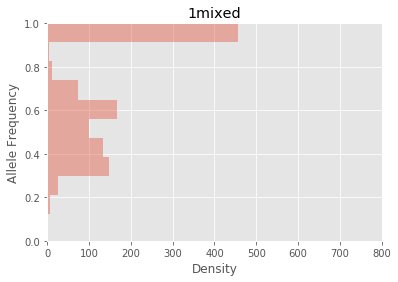

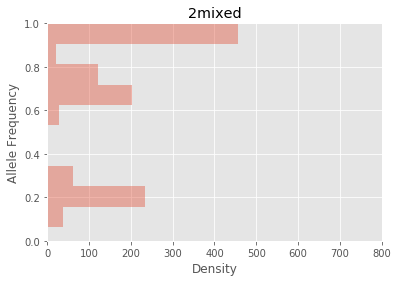

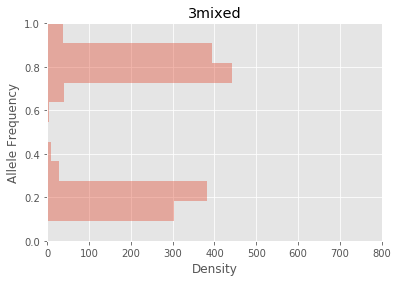

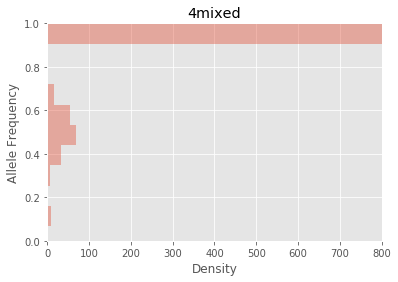

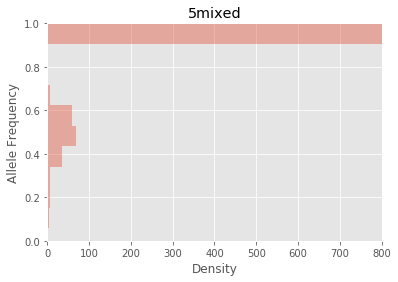

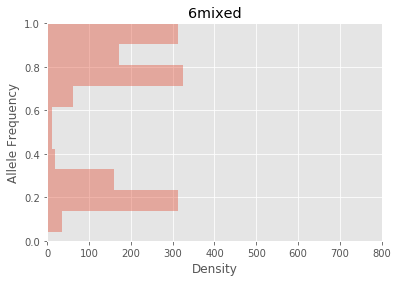

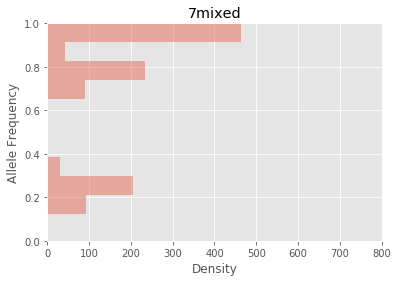

In [101]:
for name_dsf, df in dict_dff.items():
    distplot_sns(df,name_dsf)

In [59]:
def split_df_mean(vcf_df, homoz=0.95):
    filter_homoz_top = homoz
    filter_homoz_bottom = (1 - filter_homoz_top)
    
    #mean = vcf_df['AF'][(vcf_df['AF'] <= filter_homoz_top) & (vcf_df['AF'] >= filter_homoz_bottom)].mean(axis = 0)
    mean = vcf_df['AF'][(vcf_df.AC != 2) & (vcf_df.gt0 != 1)].mean(axis = 0)    


    top_positions = vcf_df['POS'][(vcf_df['AF'] >= mean) & (vcf_df.AC != 2) & (vcf_df.gt0 != 1)].tolist()
    bottom_positions = vcf_df['POS'][(vcf_df['AF'] < mean)].tolist()
    
    return top_positions, bottom_positions

In [60]:
dict_t_b = {}
for name_dff, df_dff in dict_dff.items():
    name_top = name_dff + "_t"
    name_btm = name_dff + "_b"
    name_top , name_btm = split_df_mean(df_dff)
    dict_t_b[name_dff] = name_top , name_btm

# Extract Population Frequency by Allele Frequency

In [75]:
def split_sample_freq(vcf_df, name):
    
    mean = vcf_df['AF'][(vcf_df.AC != 2) & (vcf_df.gt0 != 1)].mean(axis = 0)
    
    top_positions = vcf_df[(vcf_df['AF'] >= mean) & (vcf_df.AC != 2) & (vcf_df.gt0 != 1)]
    bottom_positions = vcf_df[(vcf_df['AF'] < mean)]
    
    top_positions_mean = top_positions['AF'].mean(axis = 0)
    #bottom_positions_mean = bottom_positions['AF'].mean(axis = 0)
    bottom_positions_mean = 1 - top_positions_mean    
    print("MIXED SAMPLE: %s: Pop. Freq 1: %.2g, Pop. Freq 2: %.2g" % (name, top_positions_mean, bottom_positions_mean))
    return #top_positions_mean, bottom_positions_mean

In [77]:
for name_dff, df_dff in dict_dff.items():
    split_sample_freq(df_dff, name_dff)

MIXED SAMPLE: 1mixed: Pop. Freq 1: 0.62, Pop. Freq 2: 0.38
MIXED SAMPLE: 2mixed: Pop. Freq 1: 0.71, Pop. Freq 2: 0.29
MIXED SAMPLE: 3mixed: Pop. Freq 1: 0.81, Pop. Freq 2: 0.19
MIXED SAMPLE: 4mixed: Pop. Freq 1: 0.57, Pop. Freq 2: 0.43
MIXED SAMPLE: 5mixed: Pop. Freq 1: 0.56, Pop. Freq 2: 0.44
MIXED SAMPLE: 6mixed: Pop. Freq 1: 0.78, Pop. Freq 2: 0.22
MIXED SAMPLE: 7mixed: Pop. Freq 1: 0.77, Pop. Freq 2: 0.23


# Extract position by Allele Frequency

In [78]:
for k,v in dict_t_b.items():
    print(k,len(v[0]), len(v[1]))

1mixed 334 337
2mixed 379 335
3mixed 881 723
4mixed 106 90
5mixed 109 83
6mixed 574 534
7mixed 369 332


In [86]:
def split_df_mean_todict(vcf_df):
    
    mean = vcf_df['AF'][(vcf_df.AC != 2) & (vcf_df.gt0 != 1)].mean(axis = 0)
    
    top_positions_df = vcf_df[(vcf_df['AF'] >= mean) & (vcf_df.AC != 2) & (vcf_df.gt0 != 1)]
    bottom_positions_df = vcf_df[(vcf_df['AF'] < mean)]
    
    top_positions_dict = top_positions_df.set_index('POS')['ALT'].to_dict()
    bottom_positions_dict = bottom_positions_df.set_index('POS')['ALT'].to_dict()

    return top_positions_dict, bottom_positions_dict

In [87]:
dict_allpos_dict = {}
for name_dff, df_dff in dict_dff.items():
    dict_allpos_dict[name_dff] = df_dff.set_index('POS')['ALT'].to_dict()

# Find Lineage

In [88]:
for name_dsf, dict_dsf_df in dict_allpos_dict.items():
    print(name_dsf)
    get_lineage_coll(dict_dsf_df)

1mixed
This samples belongs to linage 4
2mixed
This samples belongs to linage 4
3mixed
This samples belongs to linage 4
4mixed
This samples belongs to linage 2.2.1
5mixed
This samples belongs to linage 2.2.1
6mixed
This samples belongs to linage 4
7mixed
This samples belongs to linage 4


In [89]:
for name_dsf, dict_dsf_df in dict_allpos_dict.items():
    print(name_dsf)
    #print(dict_dsf_df)
    get_lineage_snp(dict_dsf_df)

1mixed
This strain has those lineage positions:
: 4.2.2
: 4.2

2mixed
This strain has those lineage positions:
: 4.1
: 4.1.2.1
: 4.3
: 4.1.2
: 4.3.4.2
: 4.3.4

3mixed
This strain has those lineage positions:
: 4.4.1.1
: 1
: 1.2.2
: 4.4.1

4mixed
This strain has those lineage positions:
: 2
: 2.2.1
: 2.2

5mixed
This strain has those lineage positions:
: 2
: 2.2.1
: 2.2

6mixed
This strain has those lineage positions:
: 4.3.3
: 2
: 4.3
: 2.2.1
: 2.2

7mixed
This strain has those lineage positions:
: 4.1
: 4.1.2.1
: 4.1.2
: 4.8



In [90]:
dict_dtop_dbtm = {}
for name_dff, df_dff in dict_dff.items():
    name = name_dff.split("_")[0]
    print(name_dsf)
    name_top = name + "_dtop"
    name_btm = name + "_dbtm"
    
    dict_dtop_dbtm[name_top] = split_df_mean_todict(df_dff)[0]
    dict_dtop_dbtm[name_btm] = split_df_mean_todict(df_dff)[1]

7mixed
7mixed
7mixed
7mixed
7mixed
7mixed
7mixed


In [91]:
for name_dict, dict_value in dict_dtop_dbtm.items():
    print(name_dict)
    get_lineage_snp(dict_value)

1mixed_dtop
No lineage were found

1mixed_dbtm
This strain has those lineage positions:
: 4.2.2
: 4.2

2mixed_dtop
This strain has those lineage positions:
: 4.3
: 4.3.4.2
: 4.3.4

2mixed_dbtm
This strain has those lineage positions:
: 4.1
: 4.1.2.1
: 4.1.2

3mixed_dtop
This strain has those lineage positions:
: 1
: 1.2.2

3mixed_dbtm
This strain has those lineage positions:
: 4.4.1.1
: 4.4.1

4mixed_dtop
No lineage were found

4mixed_dbtm
No lineage were found

5mixed_dtop
No lineage were found

5mixed_dbtm
No lineage were found

6mixed_dtop
This strain has those lineage positions:
: 2
: 2.2.1
: 2.2

6mixed_dbtm
This strain has those lineage positions:
: 4.3.3
: 4.3

7mixed_dtop
This strain has those lineage positions:
: 4.8

7mixed_dbtm
This strain has those lineage positions:
: 4.1
: 4.1.2.1
: 4.1.2



# Find resistance in filtered samples

In [92]:
for name_dsf, dict_dsf_df in dict_allpos_dict.items():
    print(name_dsf)
    get_resistance_snp(dict_dsf_df)

1mixed
No resistance were found

2mixed
No resistance were found

3mixed
This strain has resistance positions:
:761155:*:rifampicin (RMP)
:781687:*:streptomycin (SM)
:1417019:ethambutol_(EMB)
:2155168:*:isoniazid (INH)
:4245969:ethambutol_(EMB)
:4247431:*:ethambutol (EMB)

4mixed
This strain has resistance positions:
:781687:*:streptomycin (SM)
:781822:*:streptomycin (SM)
:1673425:*:isoniazid (INH)
:2155168:*:isoniazid (INH)
:4243221:ethambutol (EMB)
:4247429:*:ethambutol (EMB)
:4247513:ethambutol (EMB)

5mixed
This strain has resistance positions:
:7582:*:fluoroquinolones (FQ)
:781687:*:streptomycin (SM)
:2155168:*:isoniazid (INH)
:2289208:pyrazinamide (PZA)
:4243225:ethambutol (EMB)
:4247429:*:ethambutol (EMB)

6mixed
This strain has resistance positions:
:412339:ethambutol_(EMB)
:761155:*:rifampicin (RMP)
:781687:*:streptomycin (SM)
:1472359:streptomycin (SM)
:1473246:*:amikacin (AMK) kanamycin (KAN) capreomycin (CPR)
:1673425:*:isoniazid (INH)
:2155168:*:isoniazid (INH)
:2288764:*:

In [93]:
for name_dict, dict_value in dict_dtop_dbtm.items():
    print(name_dict)
    get_resistance_snp(dict_value)

1mixed_dtop
No resistance were found

1mixed_dbtm
No resistance were found

2mixed_dtop
No resistance were found

2mixed_dbtm
No resistance were found

3mixed_dtop
This strain has resistance positions:
:1417019:ethambutol_(EMB)
:4245969:ethambutol_(EMB)

3mixed_dbtm
This strain has resistance positions:
:761155:*:rifampicin (RMP)
:781687:*:streptomycin (SM)
:2155168:*:isoniazid (INH)
:4247431:*:ethambutol (EMB)

4mixed_dtop
This strain has resistance positions:
:781822:*:streptomycin (SM)
:1673425:*:isoniazid (INH)
:4247429:*:ethambutol (EMB)

4mixed_dbtm
This strain has resistance positions:
:781687:*:streptomycin (SM)
:4243221:ethambutol (EMB)
:4247513:ethambutol (EMB)

5mixed_dtop
This strain has resistance positions:
:7582:*:fluoroquinolones (FQ)
:4243225:ethambutol (EMB)
:4247429:*:ethambutol (EMB)

5mixed_dbtm
No resistance were found

6mixed_dtop
This strain has resistance positions:
:761155:*:rifampicin (RMP)
:781687:*:streptomycin (SM)

6mixed_dbtm
This strain has resistance p

# Obtain VCF files

In [130]:
def split_df_mean_vcf(vcf_df):
    #print("VCF:" , vcf_df.shape)
    mean = vcf_df['AF'][(vcf_df.AC != 2) & (vcf_df.gt0 != 1)].mean(axis = 0)    

    top_positions_vcf = vcf_df['POS'][(vcf_df['AF'] > mean) & (vcf_df['FILTER'] == "PASS")].tolist()
    bottom_positions_vcf = vcf_df['POS'][(vcf_df['AF'] < mean) & (vcf_df['FILTER'] == "PASS")].tolist()
    bottom_positions_vcf = vcf_df['POS'][((vcf_df['AF'] < mean) | (vcf_df.AC == 2)) & (vcf_df['FILTER'] == "PASS")].tolist()

    #print(len(top_positions_vcf))
    #print(len(bottom_positions_vcf))
    return top_positions_vcf, bottom_positions_vcf

In [131]:
def filter_vcf_list(raw_vcf, list_pos, name_out):
    input_vcf = os.path.abspath(raw_vcf)
    rinput_vcf_dir_name = ("/").join(input_vcf.split("/")[:-1])
     
    vcf_output_file = os.path.join(rinput_vcf_dir_name, name_out)
        
    with open(input_vcf, "r") as f:
        with open(vcf_output_file, "w") as f1:
            for line in f:
                if line.startswith("#CHROM") and not line.startswith("##"):
                    #print(line)
                    f1.write(line)
                elif not line.startswith("##")and int(line.split("\t")[1]) in list_pos:
                    #print(line)
                    f1.write(line)

In [132]:
dict_dtop_dbtm_list_vcf = {}
for name_vcf, df_vcf in dict_dff.items():
    name = name_vcf.split("_")[0]
    name_top = name + "_vcf_top.vcf"
    name_btm = name + "_vcf_btm.vcf"
    #print(name, df_vcf.shape)
    dict_dtop_dbtm_list_vcf[name_top] = split_df_mean_vcf(df_vcf)[0]
    dict_dtop_dbtm_list_vcf[name_btm] = split_df_mean_vcf(df_vcf)[1]

In [133]:
for n, d in dict_dtop_dbtm_list_vcf.items():
    print(n, len(d))

1mixed_vcf_top.vcf 791
1mixed_vcf_btm.vcf 794
2mixed_vcf_top.vcf 835
2mixed_vcf_btm.vcf 791
3mixed_vcf_top.vcf 919
3mixed_vcf_btm.vcf 761
4mixed_vcf_top.vcf 908
4mixed_vcf_btm.vcf 892
5mixed_vcf_top.vcf 911
5mixed_vcf_btm.vcf 885
6mixed_vcf_top.vcf 885
6mixed_vcf_btm.vcf 845
7mixed_vcf_top.vcf 831
7mixed_vcf_btm.vcf 794


In [134]:
#vcf_files = [vcf_1, vcf_2, vcf_3, vcf_4, vcf_5, vcf_6]
for vcf_name, list_pos in dict_dtop_dbtm_list_vcf.items():
    for file in vcf_files:
        file_split = file.split("/")[1][0:6]
        if vcf_name.startswith(file_split):
            print(file, len(list_pos), vcf_name)
            filter_vcf_list(file, list_pos, vcf_name)

coinf_it/1mixed.snp.hf.pass.vcf 791 1mixed_vcf_top.vcf
coinf_it/1mixed.snp.hf.pass.vcf 794 1mixed_vcf_btm.vcf
coinf_it/2mixed.snp.hf.pass.vcf 835 2mixed_vcf_top.vcf
coinf_it/2mixed.snp.hf.pass.vcf 791 2mixed_vcf_btm.vcf
coinf_it/3mixed.snp.hf.pass.vcf 919 3mixed_vcf_top.vcf
coinf_it/3mixed.snp.hf.pass.vcf 761 3mixed_vcf_btm.vcf
coinf_it/4mixed.snp.hf.pass.vcf 908 4mixed_vcf_top.vcf
coinf_it/4mixed.snp.hf.pass.vcf 892 4mixed_vcf_btm.vcf
coinf_it/5mixed.snp.hf.pass.vcf 911 5mixed_vcf_top.vcf
coinf_it/5mixed.snp.hf.pass.vcf 885 5mixed_vcf_btm.vcf
coinf_it/6mixed.snp.hf.pass.vcf 885 6mixed_vcf_top.vcf
coinf_it/6mixed.snp.hf.pass.vcf 845 6mixed_vcf_btm.vcf
coinf_it/7mixed.snp.hf.pass.vcf 831 7mixed_vcf_top.vcf
coinf_it/7mixed.snp.hf.pass.vcf 794 7mixed_vcf_btm.vcf
